In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import savgol_filter
from matplotlib import patches as patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
from skimage.color import rgb2lab, lab2rgb, lab2lch

#import tensorflow as tf
%matplotlib inline

from PIL import Image
from matplotlib.patches import Rectangle

import luxpy as lx

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

In [2]:
wavelength = np.linspace(400,700, 31)

def objects(path = "C:/Users/renep/Google Drive/Research//Codes/data/complete_ms_data/"):
    object  = os.listdir(path)
    #names.append()
    return object

name = objects()

def dataset_loader(datatype, imagetype):
    #datatype = "datatype"
    def loadImages(path = "C:/Users/renep/Google Drive/Research//Codes/data/complete_ms_data/" +str(datatype)+"/"+ str(datatype)+"/"):

        return[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imagetype)]

    filenames = loadImages()
    images = []
    for file in filenames:
        images.append(plt.imread(file))
        
    return images

def hs_dataset_loader(datatype, imagetype):
    def loadImages(path = "C:/Users/renep/Google Drive/Research//Codes/data/complete_ms_data/" +str(datatype)+"/"+ str(datatype)+"/"):

        return[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imagetype)]

    filenames = loadImages()
    images = np.zeros(shape=(512, 512, 31))
    for file in filenames:
        image = cv2.imread(file)
        images[:,:,filenames.index(file)] =image[:,:,0]

    return images

In [3]:
INPUT = []
INPUT_norm = []
for i in tqdm(name):
    rgb_data = dataset_loader(str(i), ".bmp")
    rgb_data = np.asarray(rgb_data)
    INPUT.append(rgb_data[0])
    INPUT_norm.append(rgb_data[0]/255)
    
#INPUT = INPUT/np.amax(255)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.64it/s]


In [4]:
INPUT[0].shape

(512, 512, 3)

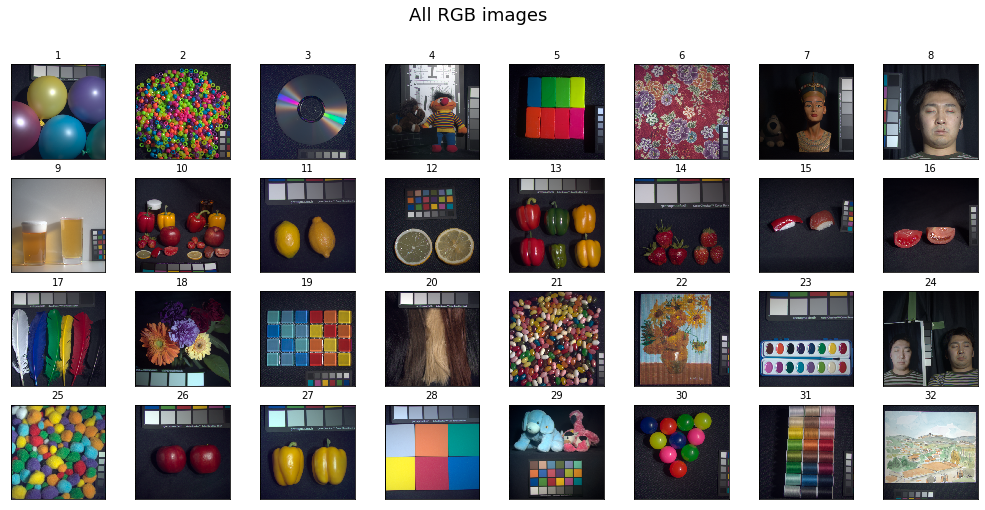

In [5]:
plt.figure(figsize=[17.5,8])
plt.rcParams['axes.titlesize'] = 10
plt.rcParams.update({'font.size': 15})

INPUT_wb = []


for i in range(32):
    
    R_w, G_w, B_w = INPUT[i][:,:,0].max(), \
                    INPUT[i][:,:,1].max(), \
                    INPUT[i][:,:,2].max()

    plt.suptitle("All RGB images")
    plt.subplot(4,8,i+1)
    plt.imshow(INPUT[i]/[R_w, G_w, B_w])
    plt.title(str(i+1))
    plt.xticks([])
    plt.yticks([])
    INPUT_wb.append(INPUT[i]/[R_w, G_w, B_w])
plt.show()

In [6]:
OUTPUT = np.zeros(shape=(32, 512, 512, 31))

for i in tqdm(name):
    hs_data = hs_dataset_loader(str(i), ".png")
    hs_data = np.asarray(hs_data)
    OUTPUT[name.index(i),:,:,:] = hs_data[:,:,:]

OUTPUT = OUTPUT/np.amax(OUTPUT)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:23<00:00,  6.37s/it]


In [27]:
results_path = "C:/Users/renep/Google Drive/Research/THESIS RESULTS/CAVE Results/"

In [9]:
RGB_overall = []
HS_overall = []
RMSE_overall = []
SAM_overall = []
DE_76_overall = []
DE_94_overall = []
DE_LUV_overall = []

#results_path = "C:/Users/renep/Google Drive/Research/RMs/RM8/"

#for i in tqdm(range(4)):
i = 2

print("Working on Hyperspectral Reconstruction")
HS = np.load(results_path + "HS_model_" + str(i+1) + ".npy")
HS_overall.append(HS)
print("Working on RGB Reconstruction")
RGB = np.load(results_path + "RGB_model_" + str(i+1) + ".npy")
RGB_overall.append(RGB)
print("Working on RMSE")
RMSE = np.load(results_path + "RMSE_model_" + str(i+1) + ".npy")
RMSE_overall.append(np.nan_to_num(RMSE).flatten())
print("Working on SAM")
SAM = np.load(results_path + "SAM_model_" + str(i+1) + ".npy")
SAM_overall.append(np.nan_to_num(SAM).flatten())
print("Working on DE 76")
DE_76 = np.load(results_path + "DE_76_model_" + str(i+1) + ".npy")
DE_76_overall.append(np.nan_to_num(DE_76).flatten())
print("Working on DE 94")
DE_94 = np.load(results_path + "DE_94_model_" + str(i+1) + ".npy")
DE_94_overall.append(np.nan_to_num(DE_94).flatten())
print("Working on DE LUV")
DE_LUV = np.load(results_path + "DE_LUV_model_" + str(i+1) + ".npy")
DE_LUV_overall.append(np.nan_to_num(DE_LUV).flatten())



Working on Hyperspectral Reconstruction
Working on RGB Reconstruction
Working on RMSE
Working on SAM
Working on DE 76
Working on DE 94
Working on DE LUV


In [123]:
plt.rcParams.update({'font.size': 8})
plt.rcParams['axes.titlesize'] = 8
CMAP = "hot"

def Hyperspectral(RGB,wav1, wav2, wav3):
    fig, axes = plt.subplots(1,4, figsize=(8,3), sharex=True, sharey=True, dpi=200)
    
    [axi.set_axis_off() for axi in axes.ravel()]
    
    axes[0].imshow(INPUT[RGB], cmap = 'jet')
    axes[0].set_title("Input RGB Image")
    axes[1].imshow(OUTPUT[RGB,:,:,wavelength.tolist().index(wav1)], cmap = CMAP)
    axes[1].set_title(str(wav1) + " nm")
    axes[2].imshow(OUTPUT[RGB,:,:,wavelength.tolist().index(wav2)], cmap = CMAP)
    axes[2].set_title(str(wav2) + " nm")
    im = axes[3].imshow(OUTPUT[RGB,:,:,wavelength.tolist().index(wav3)], cmap = CMAP, vmin = 0, vmax = 1)    
    axes[3].set_title(str(wav3) + " nm")
    cax = plt.axes([0.92, 0.28, 0.02,0.45])
    cb = fig.colorbar(im, cax=cax, shrink=0.5, label="reflectance")    
    cb.ax.set_ylim(0,1)
    fig.savefig(results_path + "hyper_dataset_" + str(RGB) + ".png", transparent = True, bbox_inches='tight')
    plt.show()
    
    
    fig2, axes2 = plt.subplots(1,4, figsize=(8,3), sharex=True, sharey=True, dpi=200)

    [axi.set_axis_off() for axi in axes2.ravel()]

    axes2[0].imshow(RGB_overall[0][RGB], cmap = 'jet')
    axes2[0].set_title("Rendered RGB Image")
    axes2[1].imshow(HS_overall[0][RGB,:,:,wavelength.tolist().index(wav1)], cmap = CMAP)
    axes2[1].set_title(str(wav1) + " nm")
    axes2[2].imshow(HS_overall[0][RGB,:,:,wavelength.tolist().index(wav2)], cmap = CMAP)
    axes2[2].set_title(str(wav2) + " nm")
    im = axes2[3].imshow(HS_overall[0][RGB,:,:,wavelength.tolist().index(wav3)], cmap = CMAP, vmin = 0, vmax = 1)    
    axes2[3].set_title(str(wav3) + " nm")
    cax = plt.axes([0.92, 0.28, 0.02,0.45])
    cb = fig2.colorbar(im, cax=cax, shrink=0.5, label="reflectance")
    cb.ax.set_ylim(0,1)
    fig2.savefig(results_path + "hyper_recon_" + str(RGB) + ".png", transparent = True, bbox_inches='tight')
    plt.show()
    

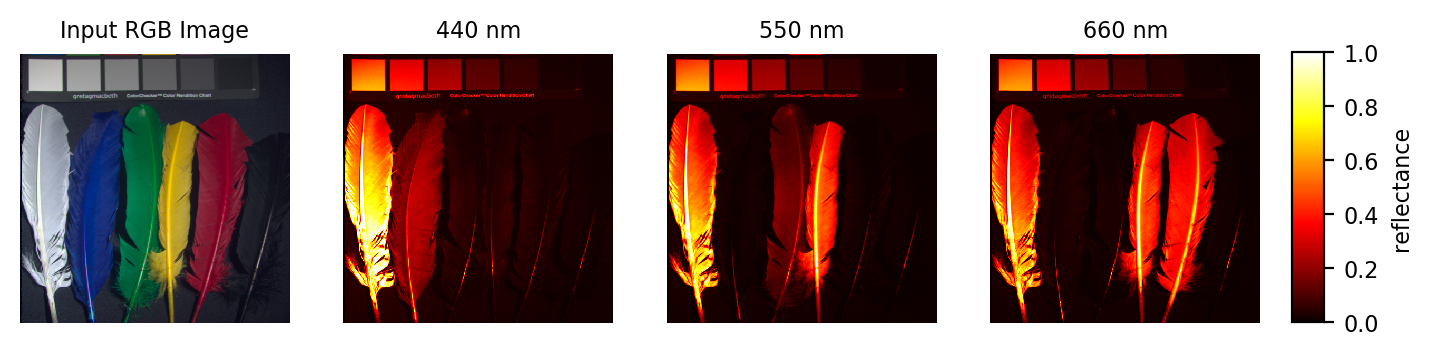

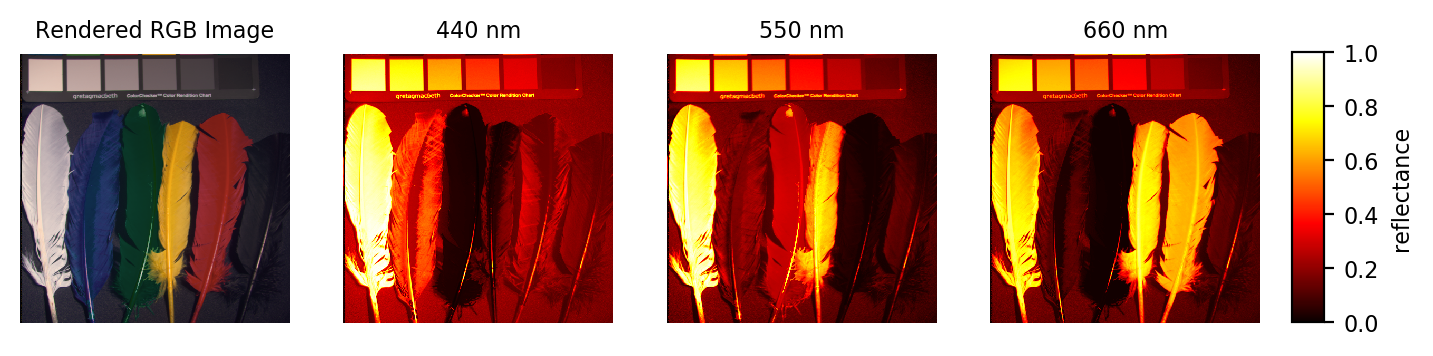

In [124]:
Hyperspectral(16,440, 550, 660)
#Hyperspectral_reconstructed(17,400, 550, 700)

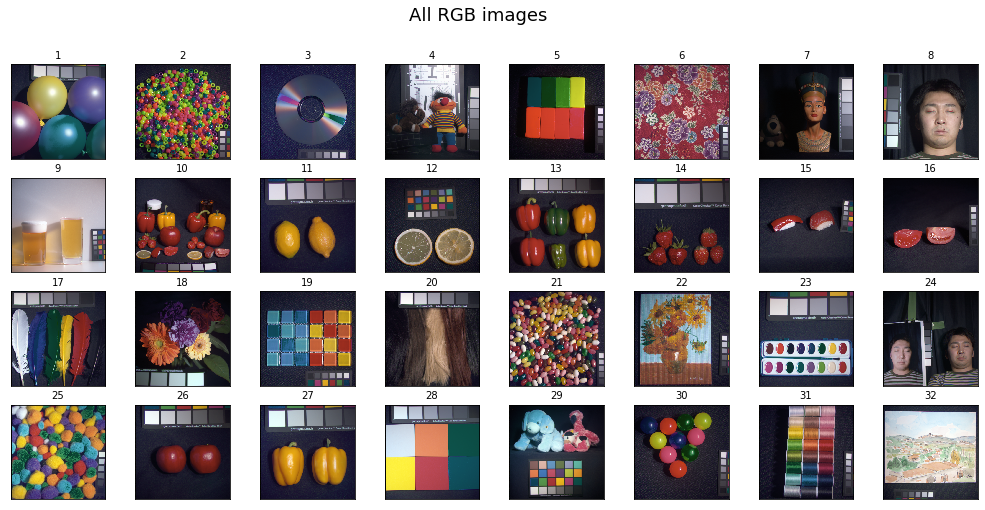

In [125]:
plt.figure(figsize=[17.5,8])
plt.rcParams['axes.titlesize'] = 10
plt.rcParams.update({'font.size': 15})

RGB_overall_wb = []

for i in range(32):
    
    R_w, G_w, B_w = RGB_overall[0][i,:,:,0].max(), \
                    RGB_overall[0][i,:,:,1].max(), \
                    RGB_overall[0][i,:,:,2].max()
    
    plt.suptitle("All RGB images")
    plt.subplot(4,8,i+1)
    plt.imshow(RGB_overall[0][i,:,:]/[R_w, G_w, B_w])
    plt.title(str(i+1))
    plt.xticks([])
    plt.yticks([])
    RGB_overall_wb.append(RGB_overall[0][i,:,:]/[R_w, G_w, B_w])
plt.show()

In [10]:
RGB_image = 4

R_w, G_w, B_w = RGB_overall[0][RGB_image,:,:,0].max(), \
                RGB_overall[0][RGB_image,:,:,1].max(), \
                RGB_overall[0][RGB_image,:,:,2].max()

In [88]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams.update({'font.size': 10})

def HS_pixel_errors(RGB_image, x_i, x_f, y_i, y_f, seed):
    
    arr = np.asarray(INPUT[RGB_image])
    hs_image_cube = np.zeros(shape=(512, 512, 31))

    p = HS_overall[0][RGB_image]
    gt = np.asarray(OUTPUT[RGB_image])
    
    np.random.seed(seed)
    wavelength = np.arange(400,701,10)
    fig, axes = plt.subplots(4,5, figsize=(9,7), sharex=True, sharey=True, dpi=100, facecolor = 'w')

    x_loc, y_loc = [],[]

    for i, ax in enumerate(axes.ravel()):

        Y, X = [np.random.randint(x_i, x_f)], [np.random.randint(y_i, y_f)]
        
        RGB = INPUT_wb[RGB_image][Y, X].astype(float)
        RGB_pred = RGB_overall_wb[RGB_image][Y, X].astype(float)
        
        pred = p[Y,X,:][0]
        act = gt[Y,X,:][0]
        ax.plot(wavelength, pred, 'w-', lw = 3 )
        ax.plot(wavelength, pred, 'r--', lw = 2, label = "Predicted")
        ax.plot(wavelength, act, 'w-', lw = 3 )
        ax.plot(wavelength, act, 'b--', lw = 2, label = "Actual")
        ax.set_ylim(0,1)
        ax.set_xticks([450,650])
        ax.set_yticks([0.5,1])
    
        x_loc.append(X)
        y_loc.append(Y)
        ax.set_title(str(i+1), fontsize = 10)
        
        ax.set_facecolor(RGB_pred[0])

        #ax.text(400, 0.8, '$\Theta$ = ' + str(np.round((alpha), 5)))
        #ax.text(400, 0.9, '$RMSE$ = ' + str(np.round((np.sqrt(mse)), 5)))
        rect = Rectangle((400,0),150,1, facecolor = RGB[0])
        ax.add_patch(rect)
        
    #plt.legend(loc = 5)
    legend = ax.legend(bbox_to_anchor=(0.95,5.3), fancybox = True)
    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(0.8) #deals with transparency
    #plt.suptitle(name[RGB_image])
    fig.savefig(results_path + "CAVE_pix_errors_" + str(RGB_image+1) + ".png")
    
    f = plt.figure(figsize=(9,4), dpi = 100)
    plt.subplot(121)
    plt.imshow(INPUT_wb[RGB_image])
    plt.title("Ground Truth RGB")
    for i in range(len(x_loc)):
        x, y = x_loc[i],y_loc[i]
        plt.gca().add_patch(Rectangle((x[0]-5,y[0]-5),10,10,linewidth=3,edgecolor='y',facecolor='none'))
        plt.text(x[0]+10,y[0]+15, str(i+1), color ='w', fontsize=10)
        plt.plot(x[0],y[0], 'r.')
        
    plt.subplot(122)
    plt.title("Predicted RGB")
    plt.imshow(RGB_overall_wb[RGB_image])
    
    for i in range(len(x_loc)):
        x, y = x_loc[i],y_loc[i]
        plt.gca().add_patch(Rectangle((x[0]-5,y[0]-5),10,10,linewidth=3,edgecolor='y',facecolor='none'))
        plt.text(x[0]+10,y[0]+15, str(i+1), color ='w', fontsize=10)
        plt.plot(x[0],y[0], 'b.')
        
    f.savefig(results_path + "CAVE_RGB_comp_" + str(RGB_image+1) + ".png")


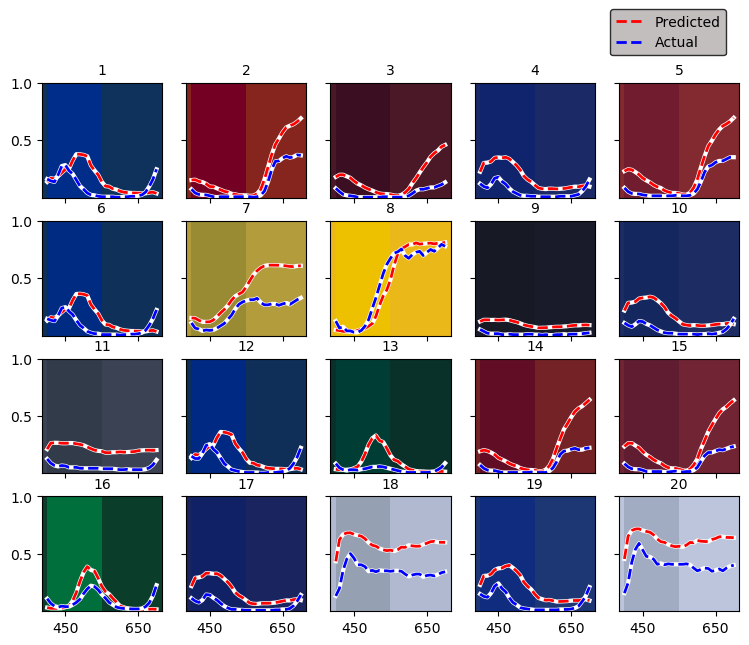

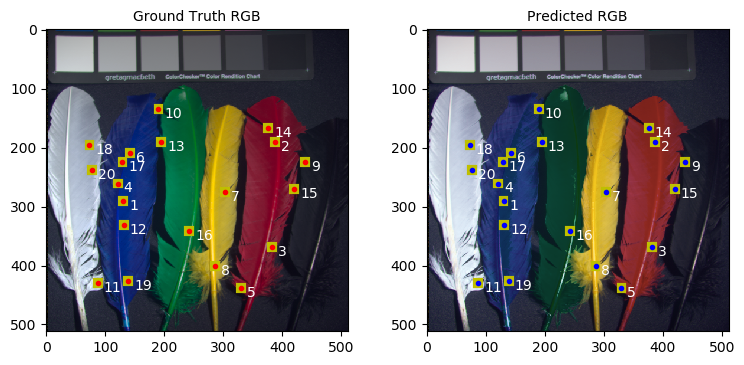

In [102]:
HS_pixel_errors(16, 100, 450, 50, 450, 11)

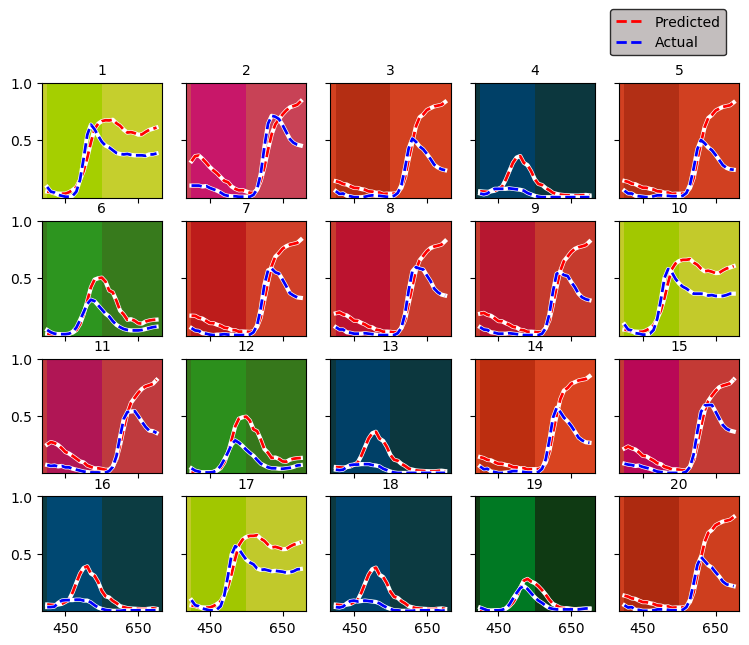

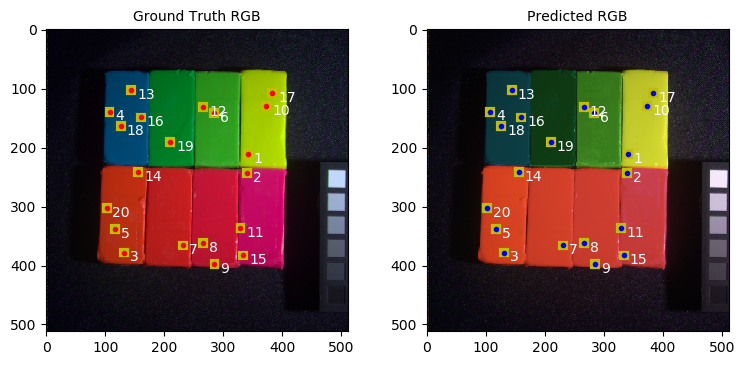

In [106]:
HS_pixel_errors(4, 100, 400, 100, 400, 17)

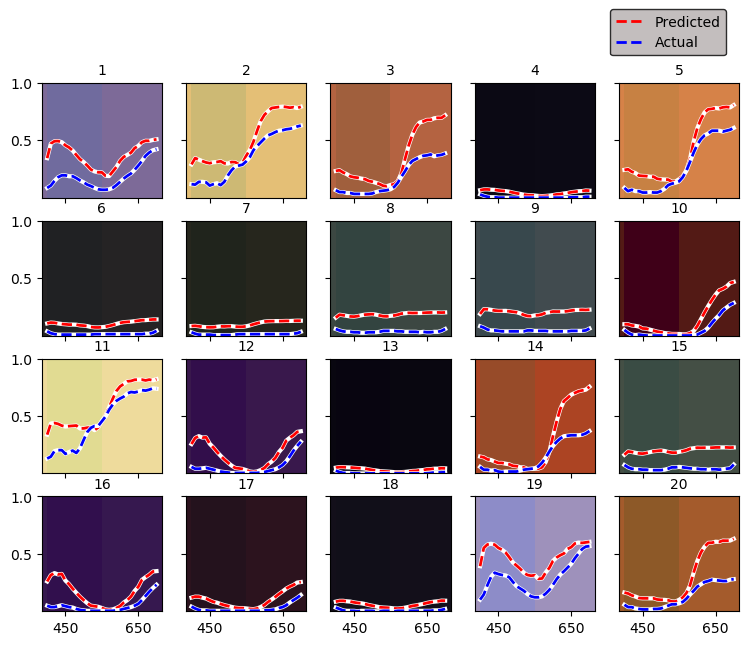

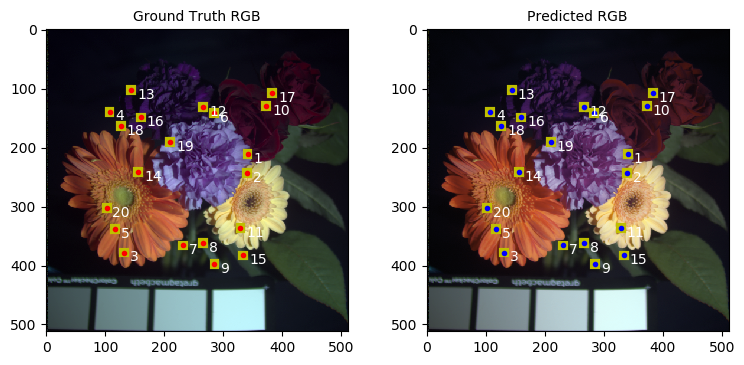

In [107]:
HS_pixel_errors(17, 100, 400, 100, 400, 17)

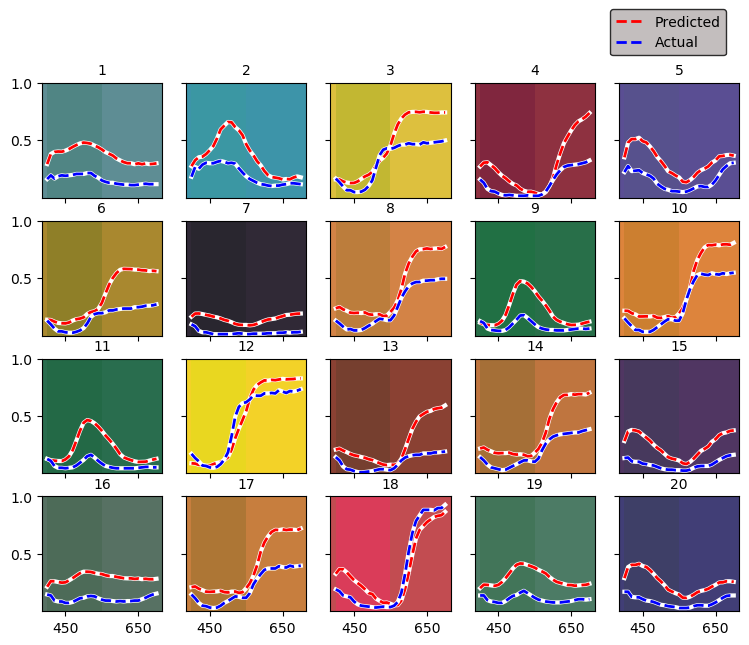

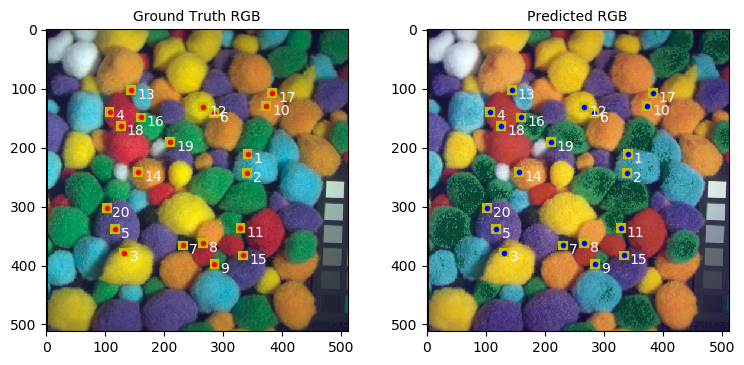

In [108]:
HS_pixel_errors(24, 100, 400, 100, 400, 17)

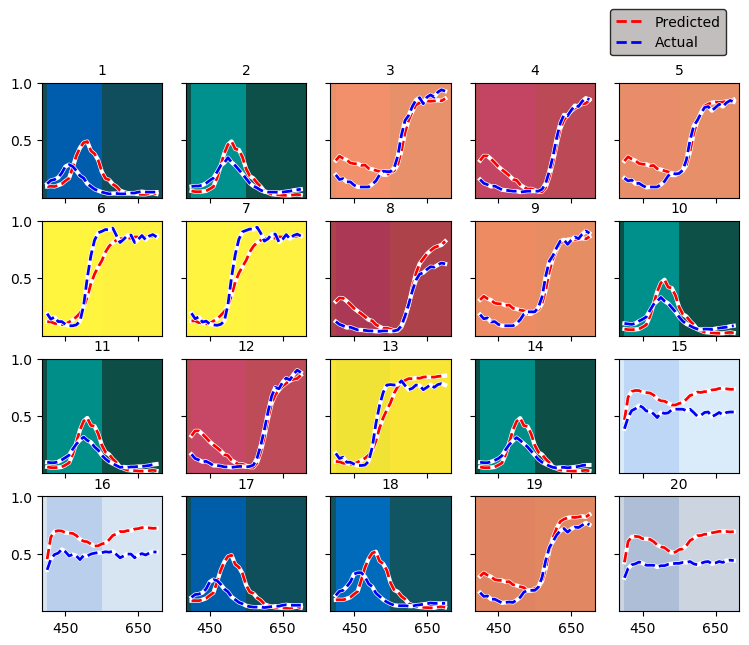

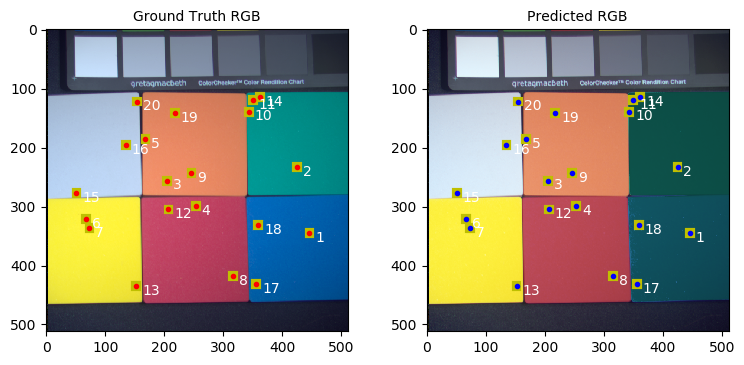

In [116]:
HS_pixel_errors(27, 100, 450, 50, 450, 15)

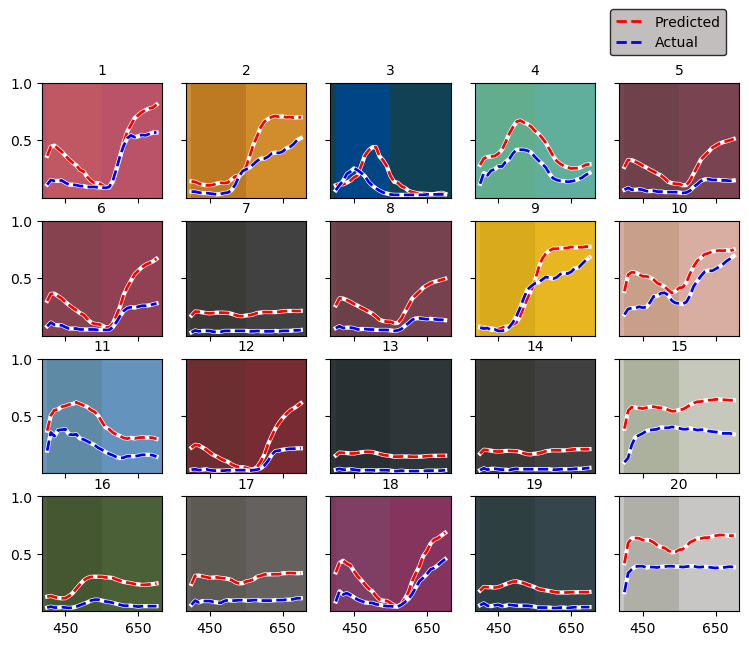

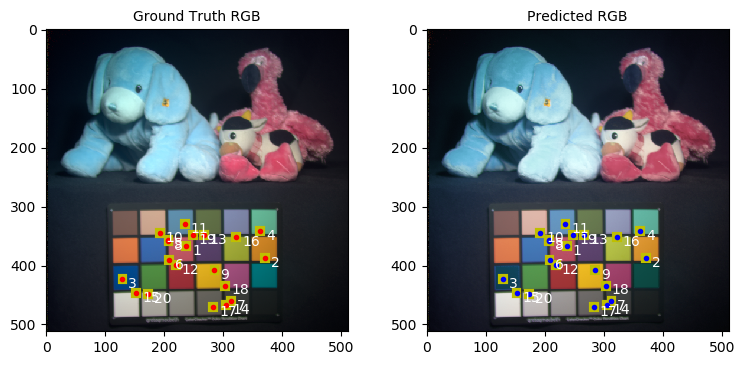

In [123]:
HS_pixel_errors(28, 320, 480, 120, 380, 0)

In [126]:
L_cave, C_cave, H_cave, A_cave, B_cave = [],[],[],[],[]
R_c, G_c, B_c = [],[],[]

for n in tqdm(range(32)):
    LAB = rgb2lab(INPUT[n])
    LCH = lab2lch(LAB)
    RGB = INPUT[n]
    r,g,b = (RGB[:,:,0]).flatten(), (RGB[:,:,1]).flatten(), (RGB[:,:,2]).flatten()
    R_c.append(r)
    G_c.append(g)
    B_c.append(b)
    A_cave.append(LAB[:,:,1].flatten())
    B_cave.append(LAB[:,:,2].flatten())
    L_cave.append(LCH[:,:,0].flatten())
    C_cave.append(LCH[:,:,1].flatten())
    H_cave.append(LCH[:,:,2].flatten())
    
L_cave, C_cave, H_cave = np.asarray(L_cave).flatten(), np.asarray(C_cave).flatten(), np.asarray(H_cave).flatten()
A_cave, B_cave =  np.asarray(A_cave).flatten(), np.asarray(B_cave).flatten()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.09it/s]


C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys
C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if sys.path[0] == '':
C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


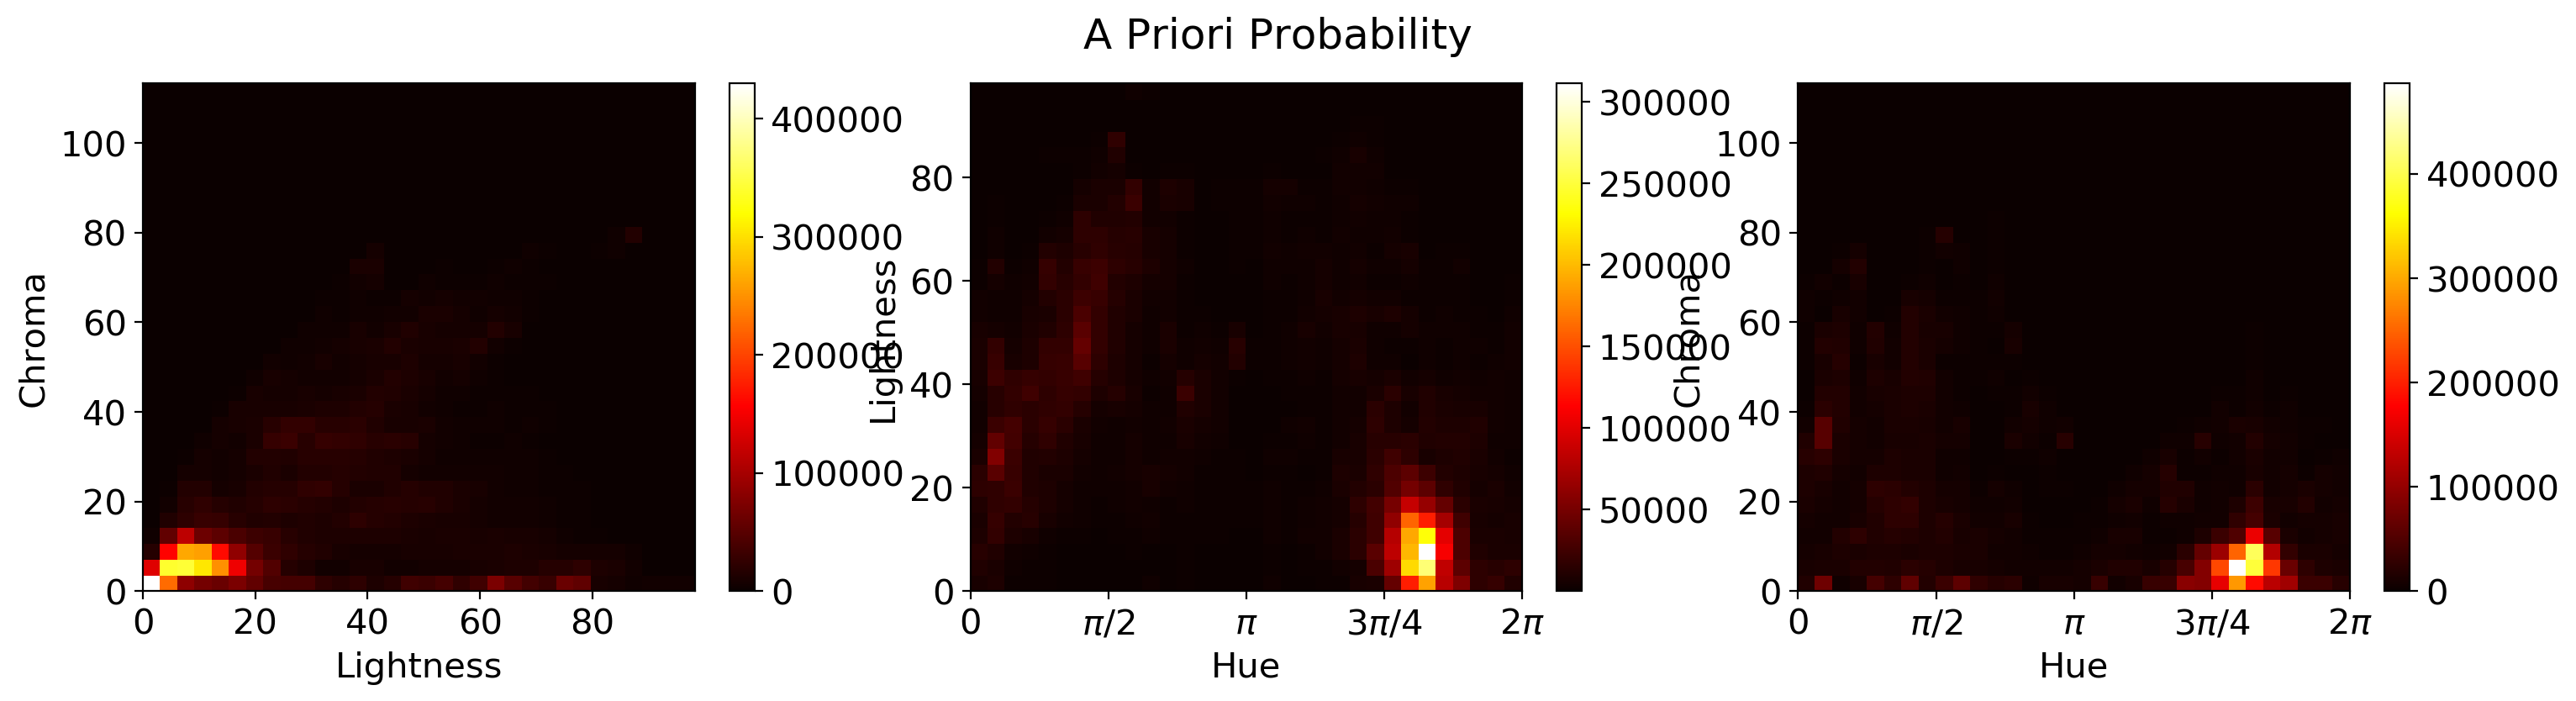

In [127]:
fig = plt.figure(figsize = [18,4], dpi = 200, facecolor = 'w')
BINS = 32
CMAP = 'hot'

plt.suptitle("A Priori Probability")
plt.subplot(131)
H, XX, YY, im = plt.hist2d(L_cave, C_cave, bins = BINS, cmap = CMAP, normed = False)
plt.ylabel("Chroma")
plt.xlabel("Lightness")
plt.colorbar()
plt.subplot(132)
H, XX, YY, im = plt.hist2d(H_cave, L_cave, bins = BINS, cmap = CMAP, normed = False)
plt.ylabel("Lightness")
plt.xlabel("Hue")

plt.xticks(np.linspace(0,2*np.pi,5),["0", "$\pi$/2",  "$\pi$", "3$\pi$/4", "2$\pi$"])
plt.colorbar()
plt.subplot(133)
H, XX, YY, im = plt.hist2d(H_cave, C_cave, bins = BINS, cmap = CMAP, normed = False)
plt.ylabel("Chroma")
plt.xlabel("Hue")
plt.xticks(np.linspace(0,2*np.pi,5),["0", "$\pi$/2",  "$\pi$", "3$\pi$/4", "2$\pi$"])
plt.colorbar()

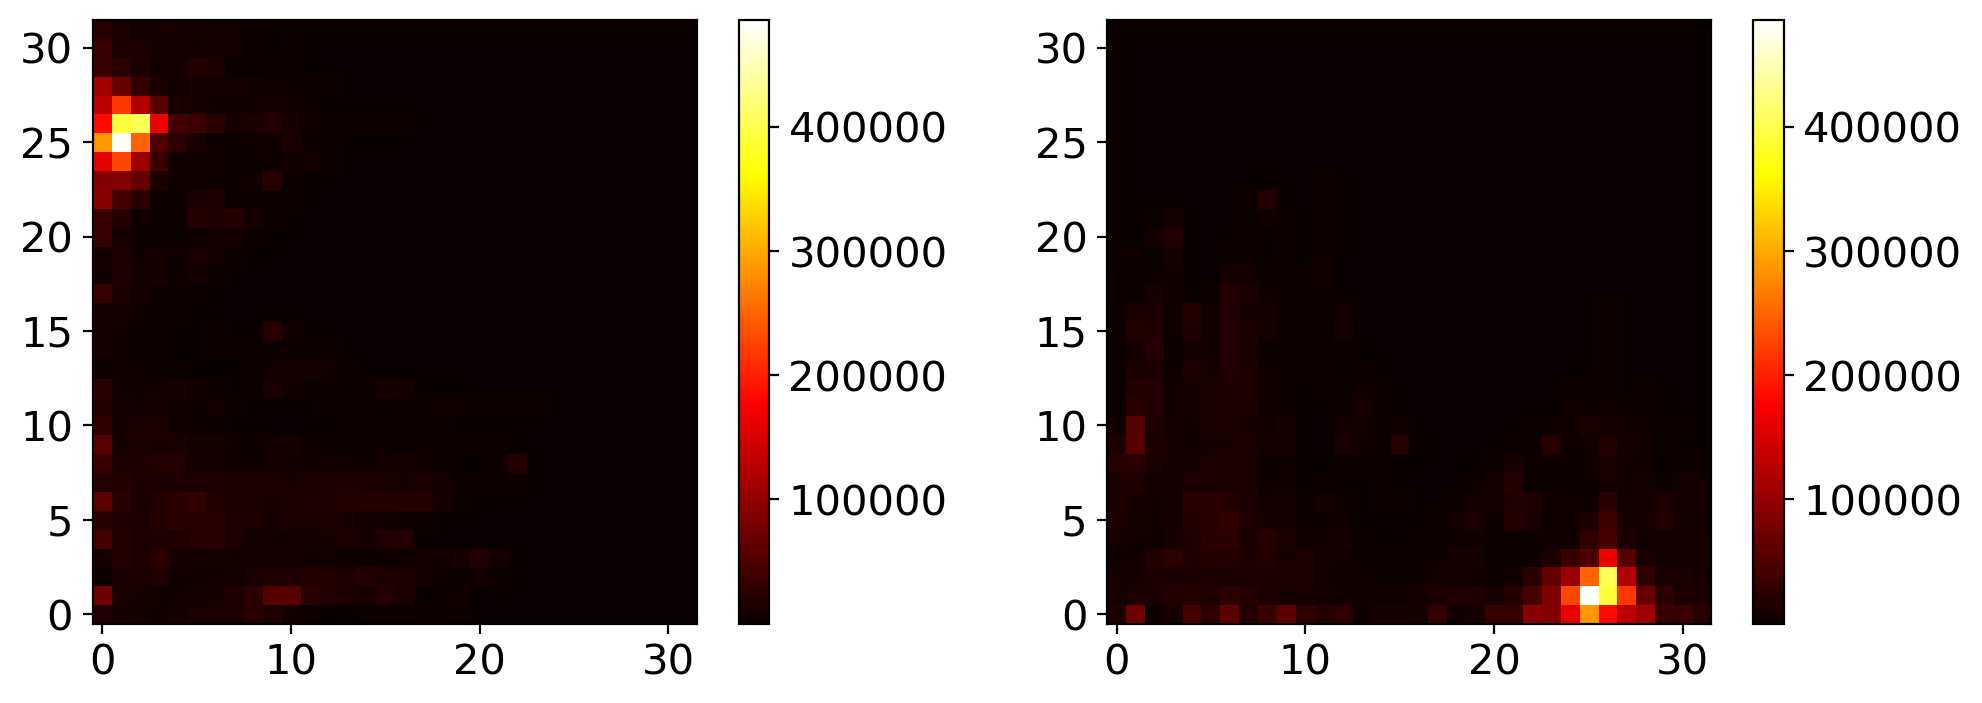

In [128]:
XX_test = (XX*(BINS)).astype(int)
YY_test = (YY*(BINS)).astype(int)
m = len(H_cave)
h_test = (H_cave[:m]*32).astype(int)
c_test = (C_cave[:m]*32).astype(int)
h_ind = np.digitize(h_test, XX_test)-1
c_ind = np.digitize(c_test, YY_test)-1
count = np.fliplr(np.rot90(H,3))

count[count == 0] = 1

plt.figure(figsize = [12,4],dpi = 200)
plt.subplot(121)
plt.imshow(H, cmap = CMAP, origin = 'lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(count, cmap = CMAP, origin = 'lower')
plt.colorbar()


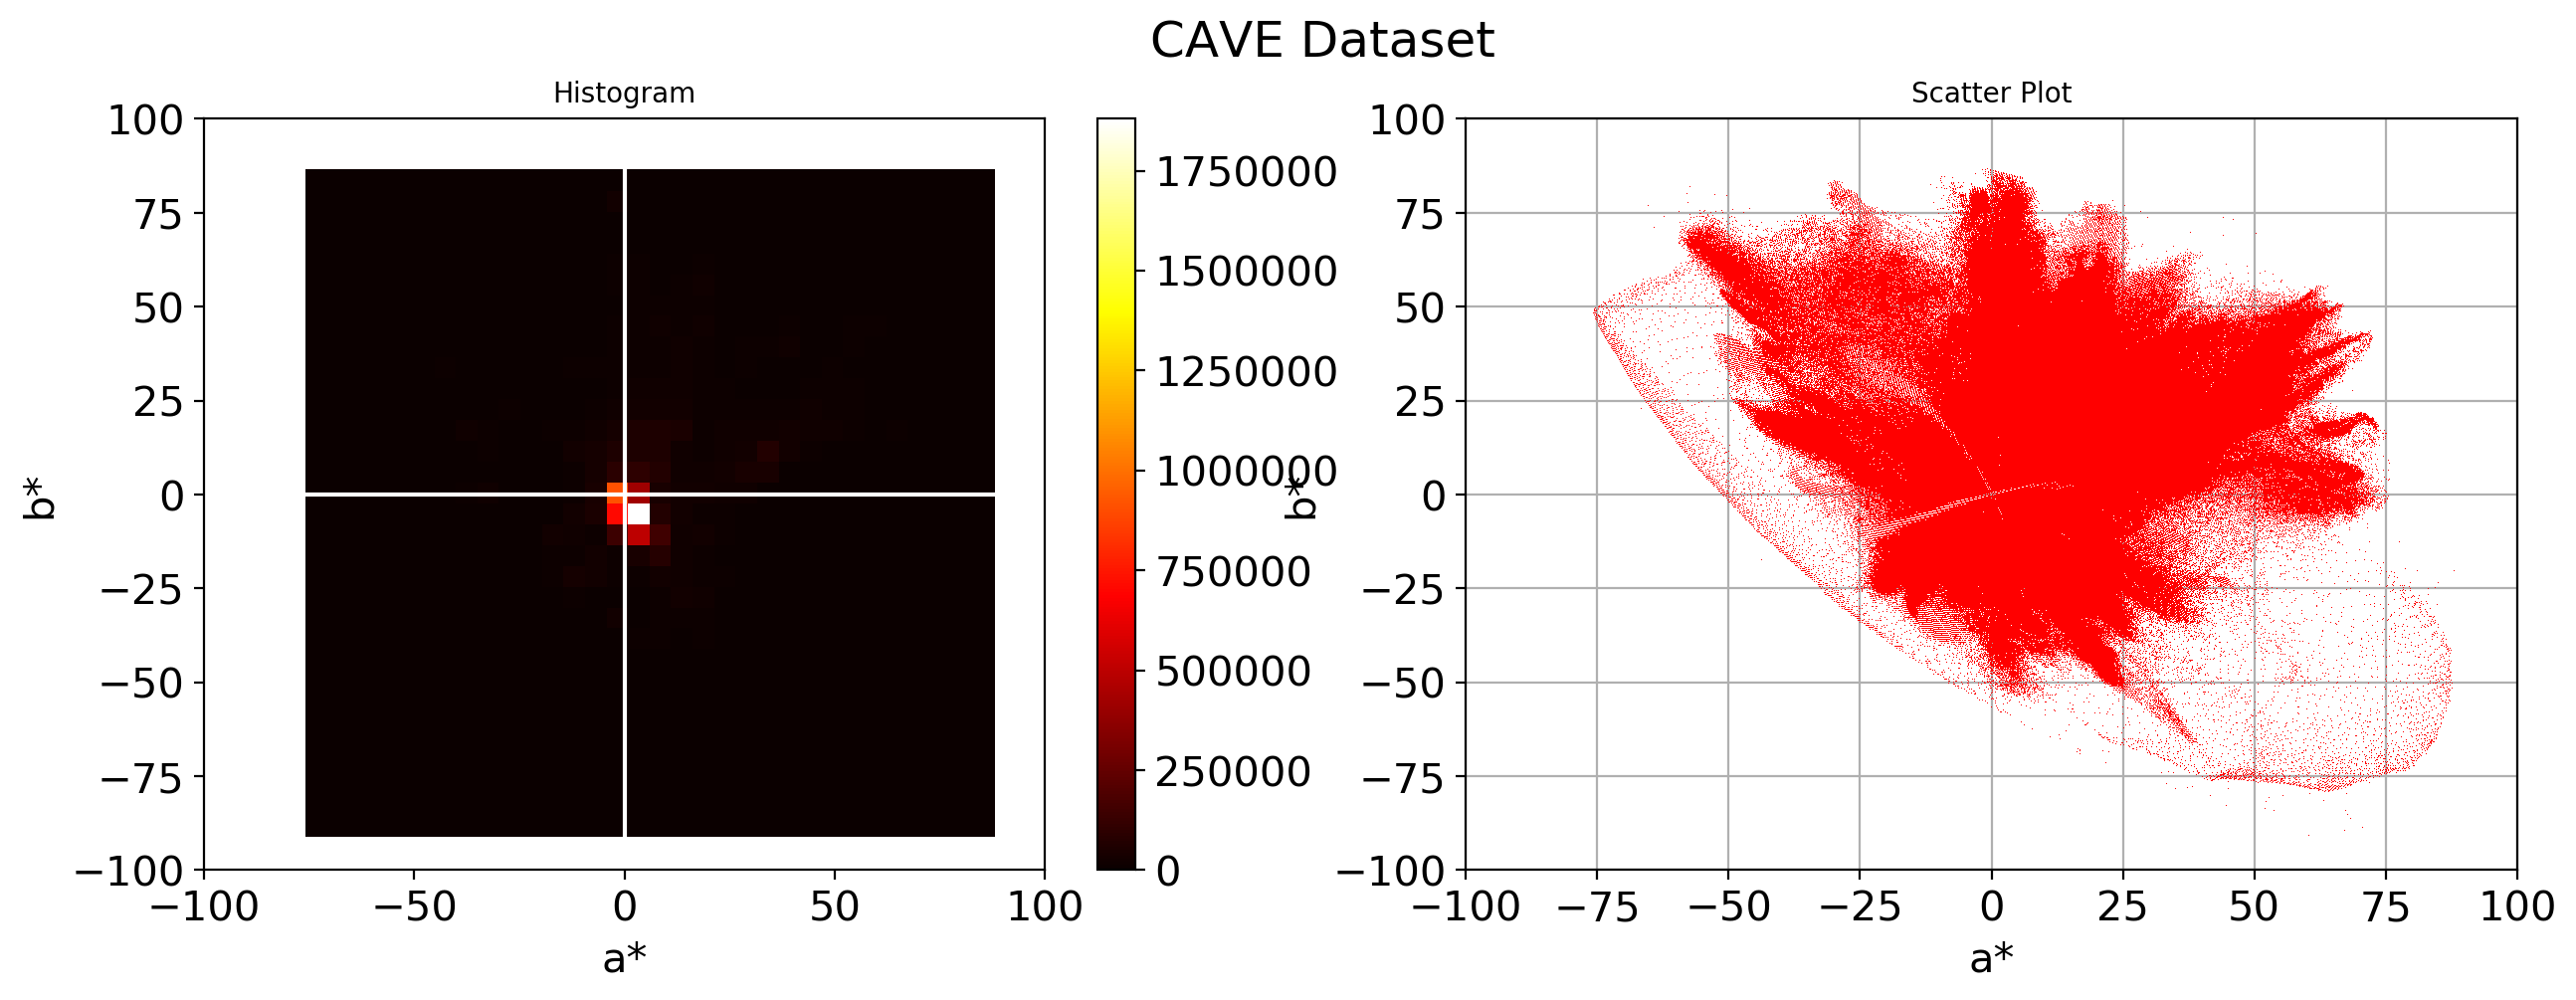

In [130]:
fig = plt.figure(figsize = [15,5], dpi = 200, facecolor = 'w')

plt.suptitle("CAVE Dataset")
plt.subplot(121)
H_ab, XX_ab, YY_ab, im = plt.hist2d(A_cave, B_cave, bins = 32, cmap = CMAP)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.ylabel("b*")
plt.xlabel("a*")
plt.colorbar()
plt.title("Histogram")
plt.axhline(0, color = 'w')
plt.axvline(0, color = 'w')

plt.subplot(122)
plt.plot(A_cave, B_cave, 'r,')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.title("Scatter Plot")
plt.ylabel("b*")
plt.xlabel("a*")

plt.grid()

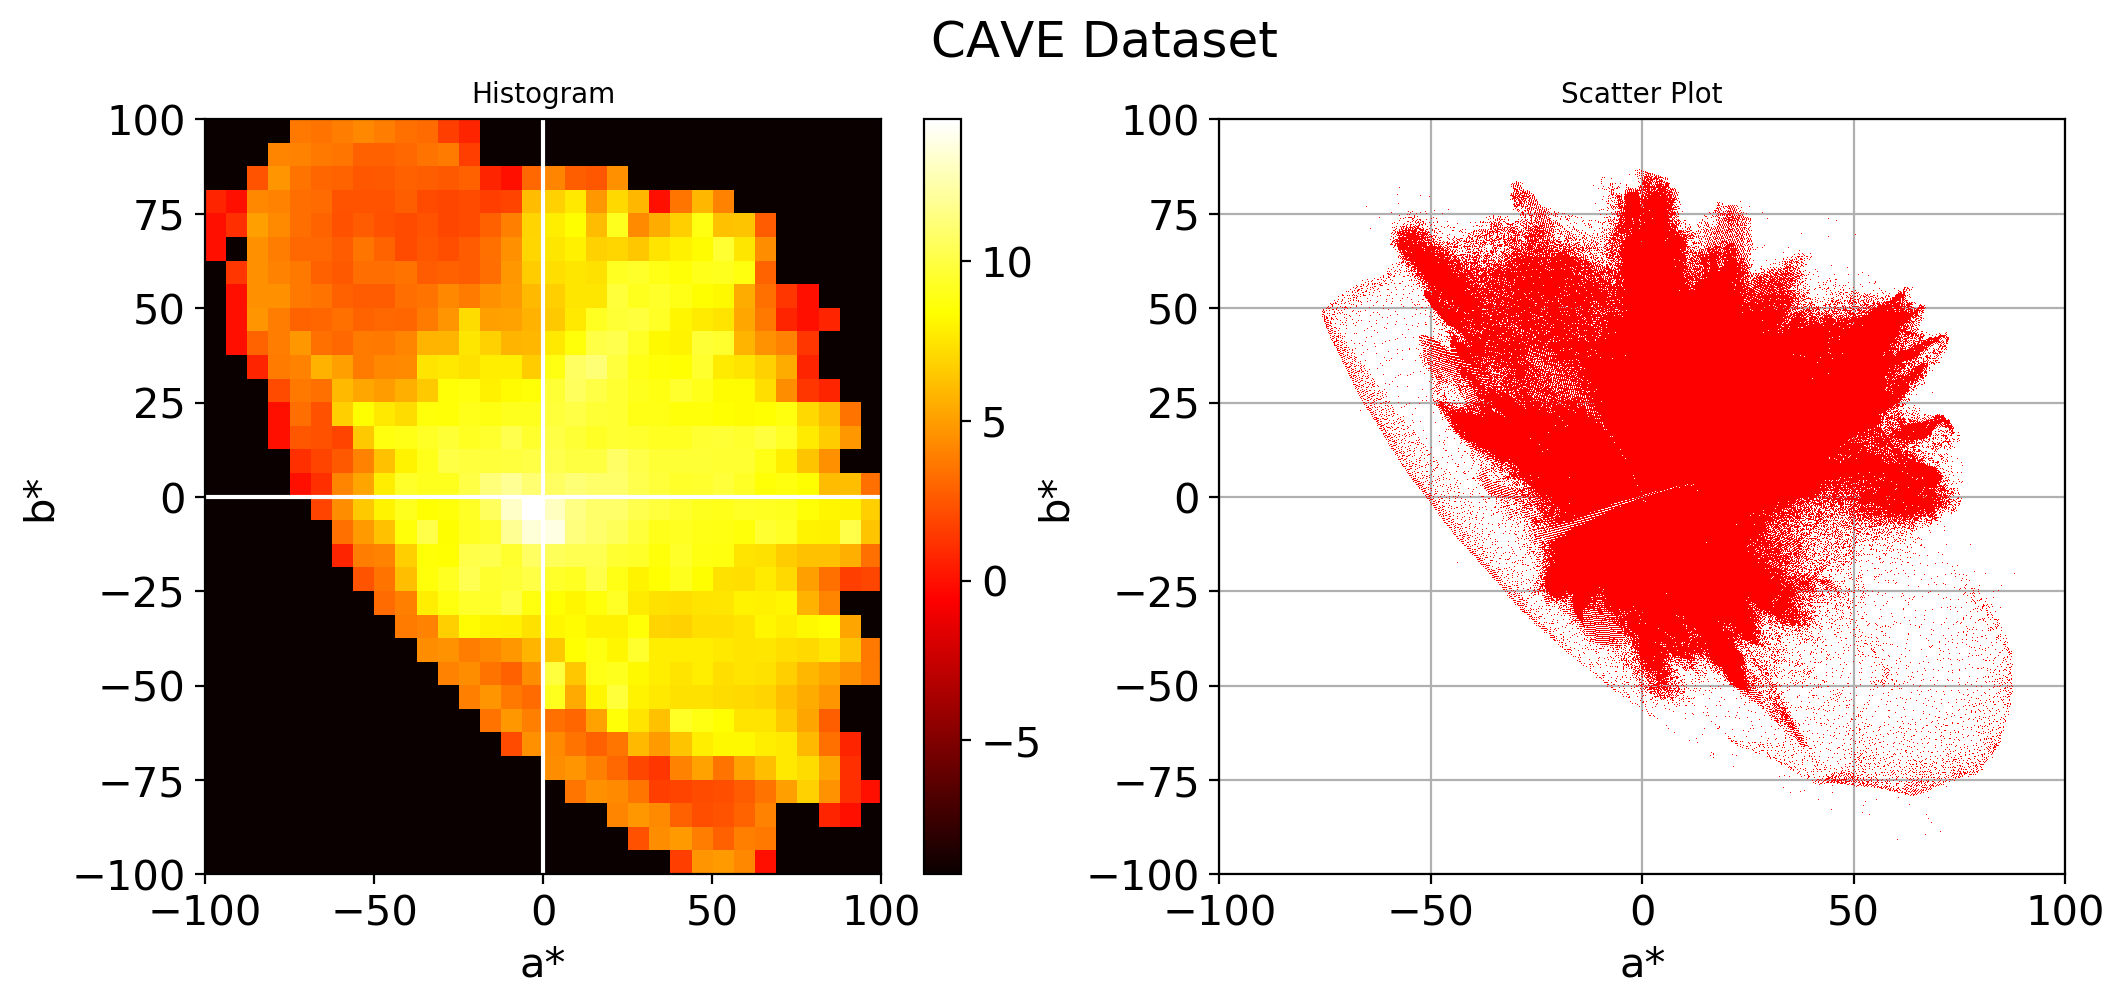

In [131]:
results_path = "C:/Users/renep/Google Drive/Research/THESIS RESULTS/Error Tendencies/"


fig = plt.figure(figsize = [12,5], dpi = 200, facecolor = 'w')

H_ab[H_ab == 0] = 0.0001


plt.suptitle("CAVE Dataset")
plt.subplot(121)
plt.imshow(np.log(H_ab), cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
#plt.xlim(-100,100)
#plt.ylim(-100,100)
plt.ylabel("b*")
plt.xlabel("a*")
plt.colorbar()
plt.title("Histogram")
plt.axhline(0, color = 'w')
plt.axvline(0, color = 'w')

plt.subplot(122)
plt.plot(A_cave, B_cave, 'r,')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.title("Scatter Plot")
plt.ylabel("b*")
plt.xlabel("a*")

plt.grid()
fig.savefig(results_path + "CAVE A Priori" + ".png", bbox_inches='tight')


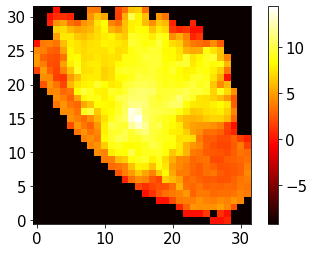

In [132]:
m = len(A_cave)
a_test = (A_cave[:m]).astype(int)
b_test = (B_cave[:m]).astype(int)
a_ind = np.digitize(a_test, XX_ab.astype(int))-1
b_ind = np.digitize(b_test, YY_ab.astype(int))-1

count_ab = H_ab
count_ab = np.fliplr(np.rot90(H_ab,3))
count_ab[count_ab == 0] = 0.0001

plt.imshow(np.log(count_ab), cmap = CMAP, origin = 'lower')
plt.colorbar()

In [133]:
ERR = []
for i in range(1024):
    e = []
    ERR.append(e)


In [134]:
metric = RMSE_overall[0]
for i in range(len(metric)):
    error = metric[i]
    x,y = a_ind[i],b_ind[i]
    m = (x-1)*32 + (y-1)
    ERR[m].append(error)

In [135]:
MEAN = []
STD = []

for i in range(1024):
    MEAN.append(np.mean(ERR[i]))
    STD.append(np.std(ERR[i]))    
    
MEAN = np.nan_to_num(np.array(MEAN).reshape(32,32))
STD = np.nan_to_num(np.array(STD).reshape(32,32))

C:\Users\renep\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\renep\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\renep\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\renep\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\renep\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


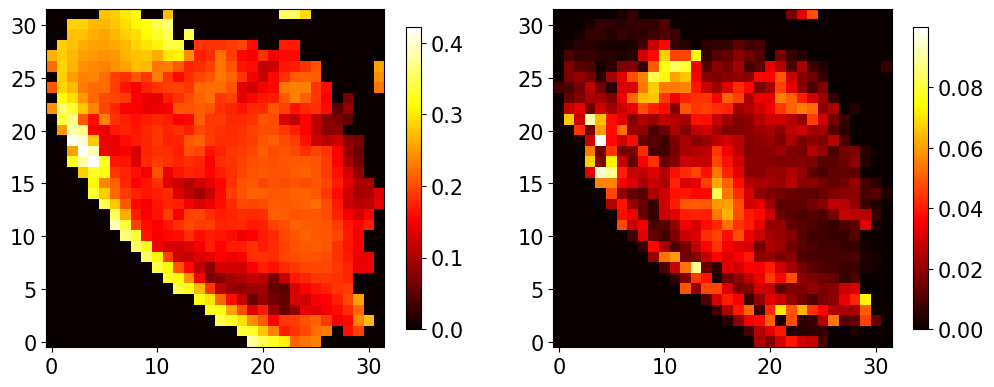

In [136]:
plt.figure(figsize = [12,5], dpi = 100)
plt.subplot(121)
plt.imshow(MEAN, origin = 'lower', cmap = CMAP)
plt.colorbar(shrink=0.8)
plt.subplot(122)
plt.imshow(STD, origin = 'lower', cmap = CMAP)
plt.colorbar(shrink=0.8)

In [137]:
len(RMSE_overall)

1

In [138]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams.update({'font.size': 10})

def Error_AB(metric, clip, ERROR, title):
    
    sum_matrix = np.zeros(shape = H_ab.shape)
    heat_matrix = np.zeros(shape = H_ab.shape)
    
    ERR = []
    for i in range(1024):
        e = []
        ERR.append(e)
    
    for i in range(len(metric)):
        error = metric[i]
        x,y = a_ind[i],b_ind[i]
        m = (x-1)*32 + (y-1)
        ERR[m].append(error)
    
    MEAN = []
    STD = []

    for i in range(1024):
        MEAN.append(np.mean(ERR[i]))
        STD.append(np.std(ERR[i]))    

    MEAN = np.nan_to_num(np.array(MEAN).reshape(32,32))
    STD = np.nan_to_num(np.array(STD).reshape(32,32))

    for i in range(len(metric)):
        error = metric[i]
        sum_matrix[b_ind[i]-32,a_ind[i]-32] += error

    heat_matrix = sum_matrix/count_ab
    heat_matrix[heat_matrix> clip] = clip
    
    sum_matrix[sum_matrix == 0] = 0.0001
    sum_matrix = np.log(sum_matrix)


    fig = plt.figure(constrained_layout=False, dpi = 200, figsize=[18,5])
    
    #fig.suptitle(str(ERROR))
    gs1 = fig.add_gridspec(nrows=1, ncols=3)# left=0.05, right=0.48, wspace=0.05)

    ax1 = fig.add_subplot(gs1[0, 0])
    ax1.set_title("Cummulative Error")
    im1 = ax1.imshow(sum_matrix, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
    ax1.set_xlabel("a*")
    ax1.set_ylabel("b*")
    ax1.axhline(0, color = 'w', linewidth = 1)
    ax1.axvline(0, color = 'w', linewidth = 1)
    fig.colorbar(im1, shrink=0.8)

    ax2 = fig.add_subplot(gs1[0, 1])
    ax2.set_title("Mean")
    im2 = ax2.imshow(MEAN, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
    ax2.axhline(0, color = 'w', linewidth = 1)
    ax2.axvline(0, color = 'w', linewidth = 1)
    ax2.set_xlabel("a*")
    #ax2.set_ylabel("b*")
    fig.colorbar(im2, shrink=0.8,label=str(ERROR))
    
    ax3 = fig.add_subplot(gs1[0,2])
    ax3.set_title("Standard Deviation")

    ax3.axhline(0, color = 'w', linewidth = 1)
    ax3.axvline(0, color = 'w', linewidth = 1)
    im3 = ax3.imshow(STD, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
    fig.colorbar(im3, shrink=0.8, label=str(ERROR))
    ax3.set_xlabel("a*")
    #ax3.set_ylabel("b*")
    
    
    fig.savefig(results_path + "CAVE_ET_" + title + ".png", bbox_inches='tight')

    
    return MEAN, STD


In [139]:
m = 0

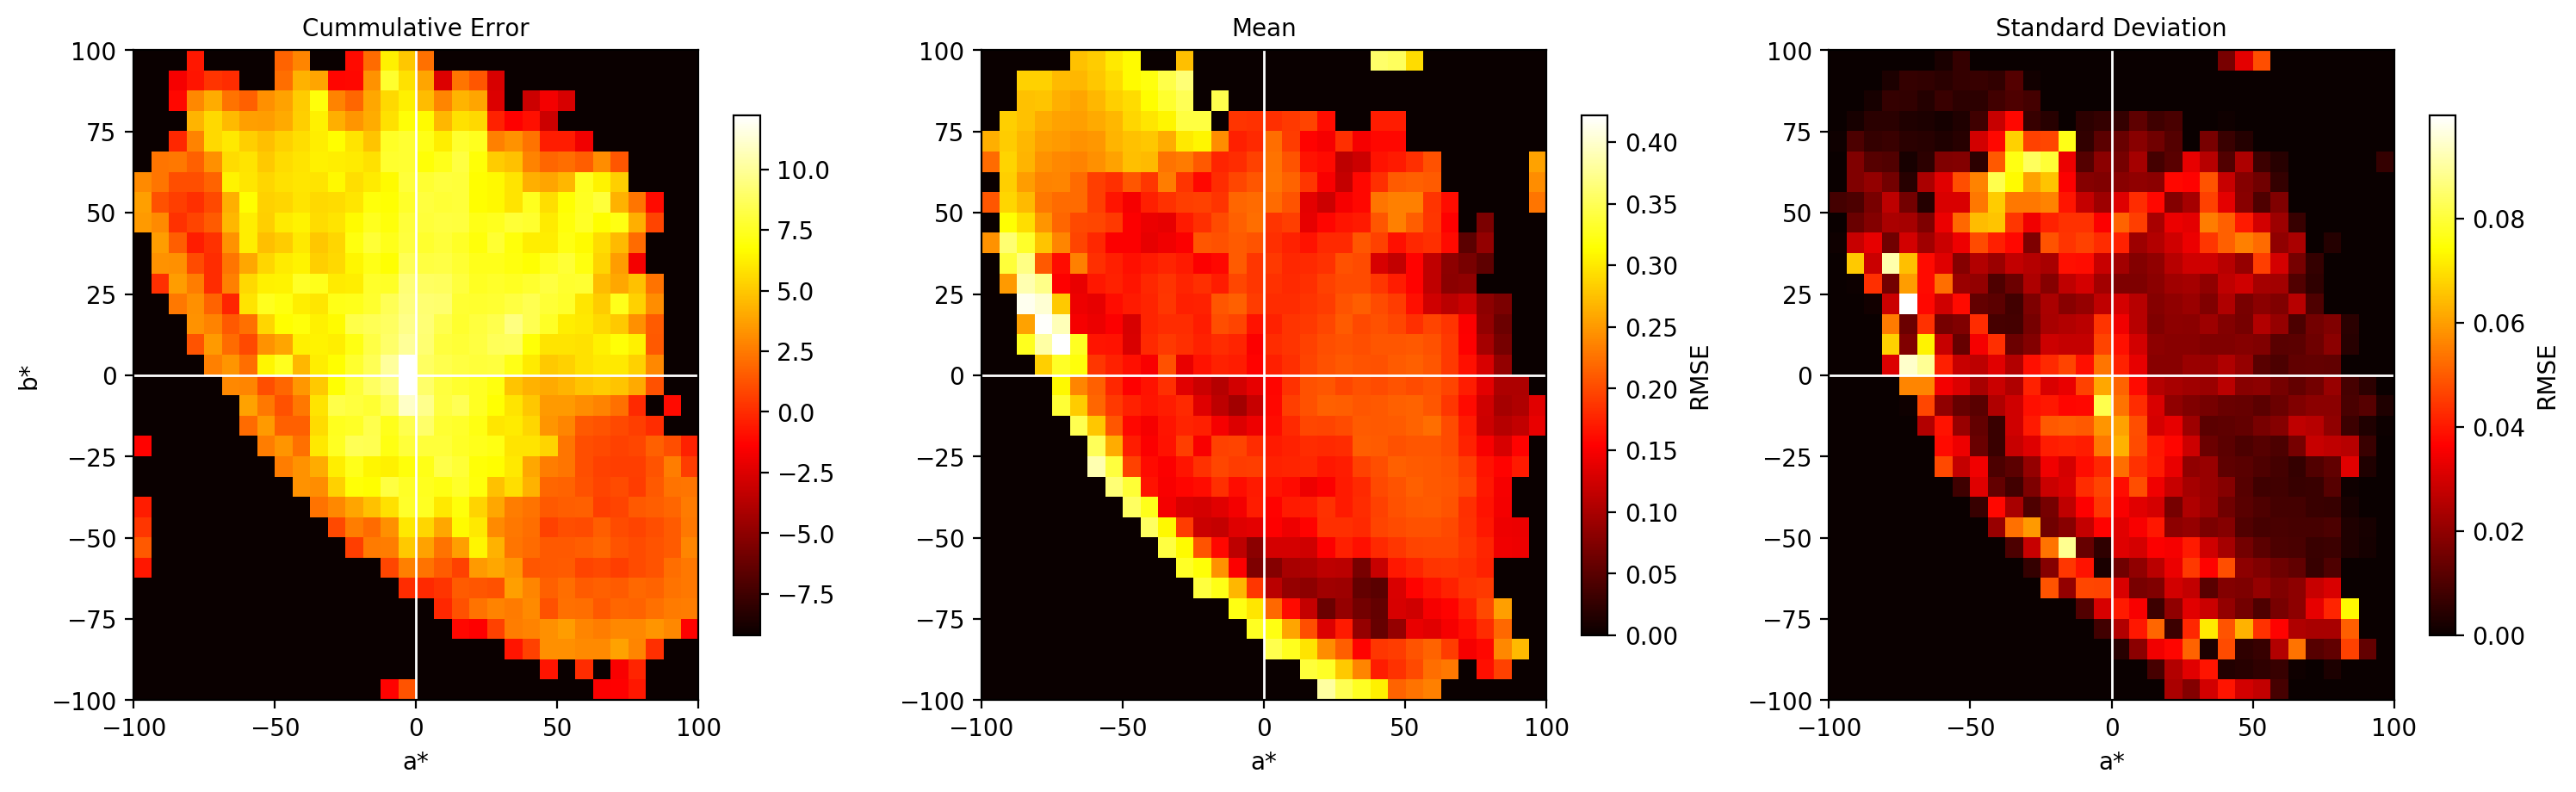

In [140]:
RMSE_mean, RMSE_std = Error_AB(RMSE_overall[0], 1, "RMSE", "RMSE")

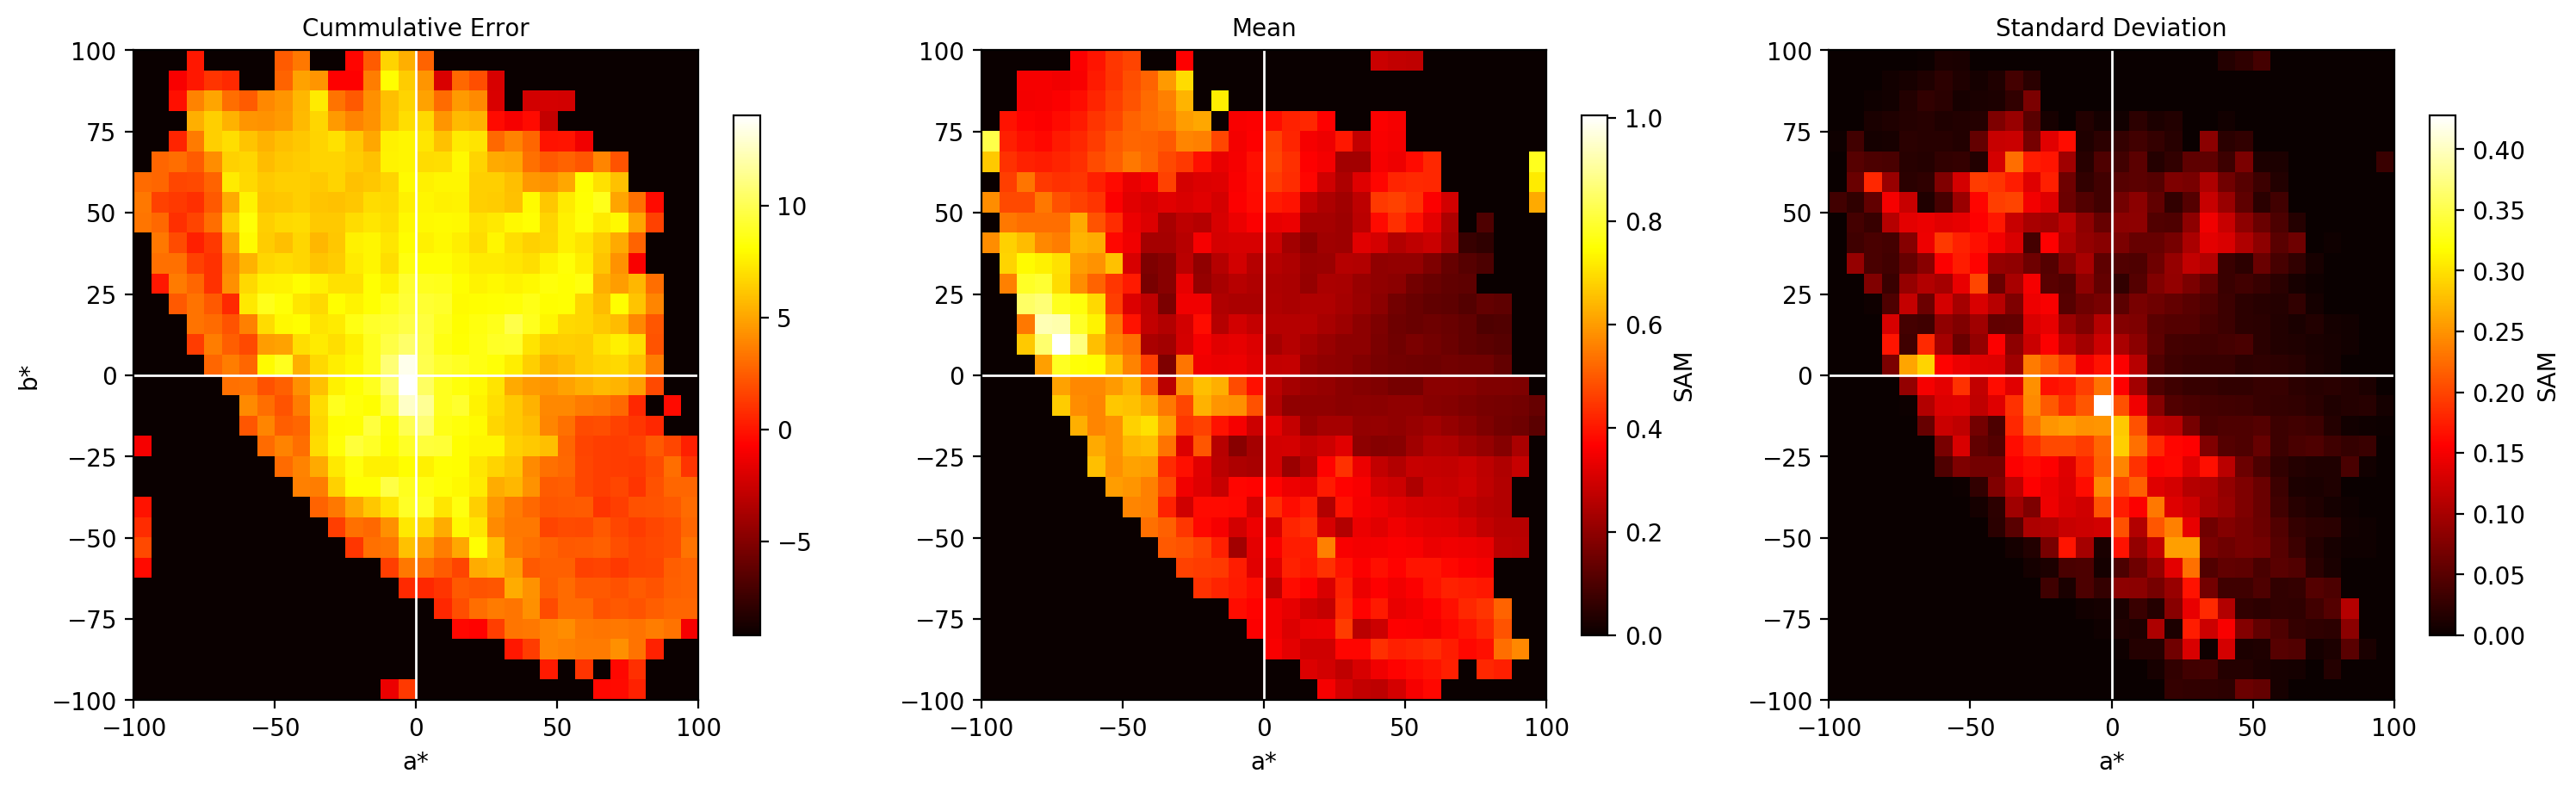

In [141]:
SAM_mean, SAM_std = Error_AB(SAM_overall[0], 1, "SAM", "SAM")

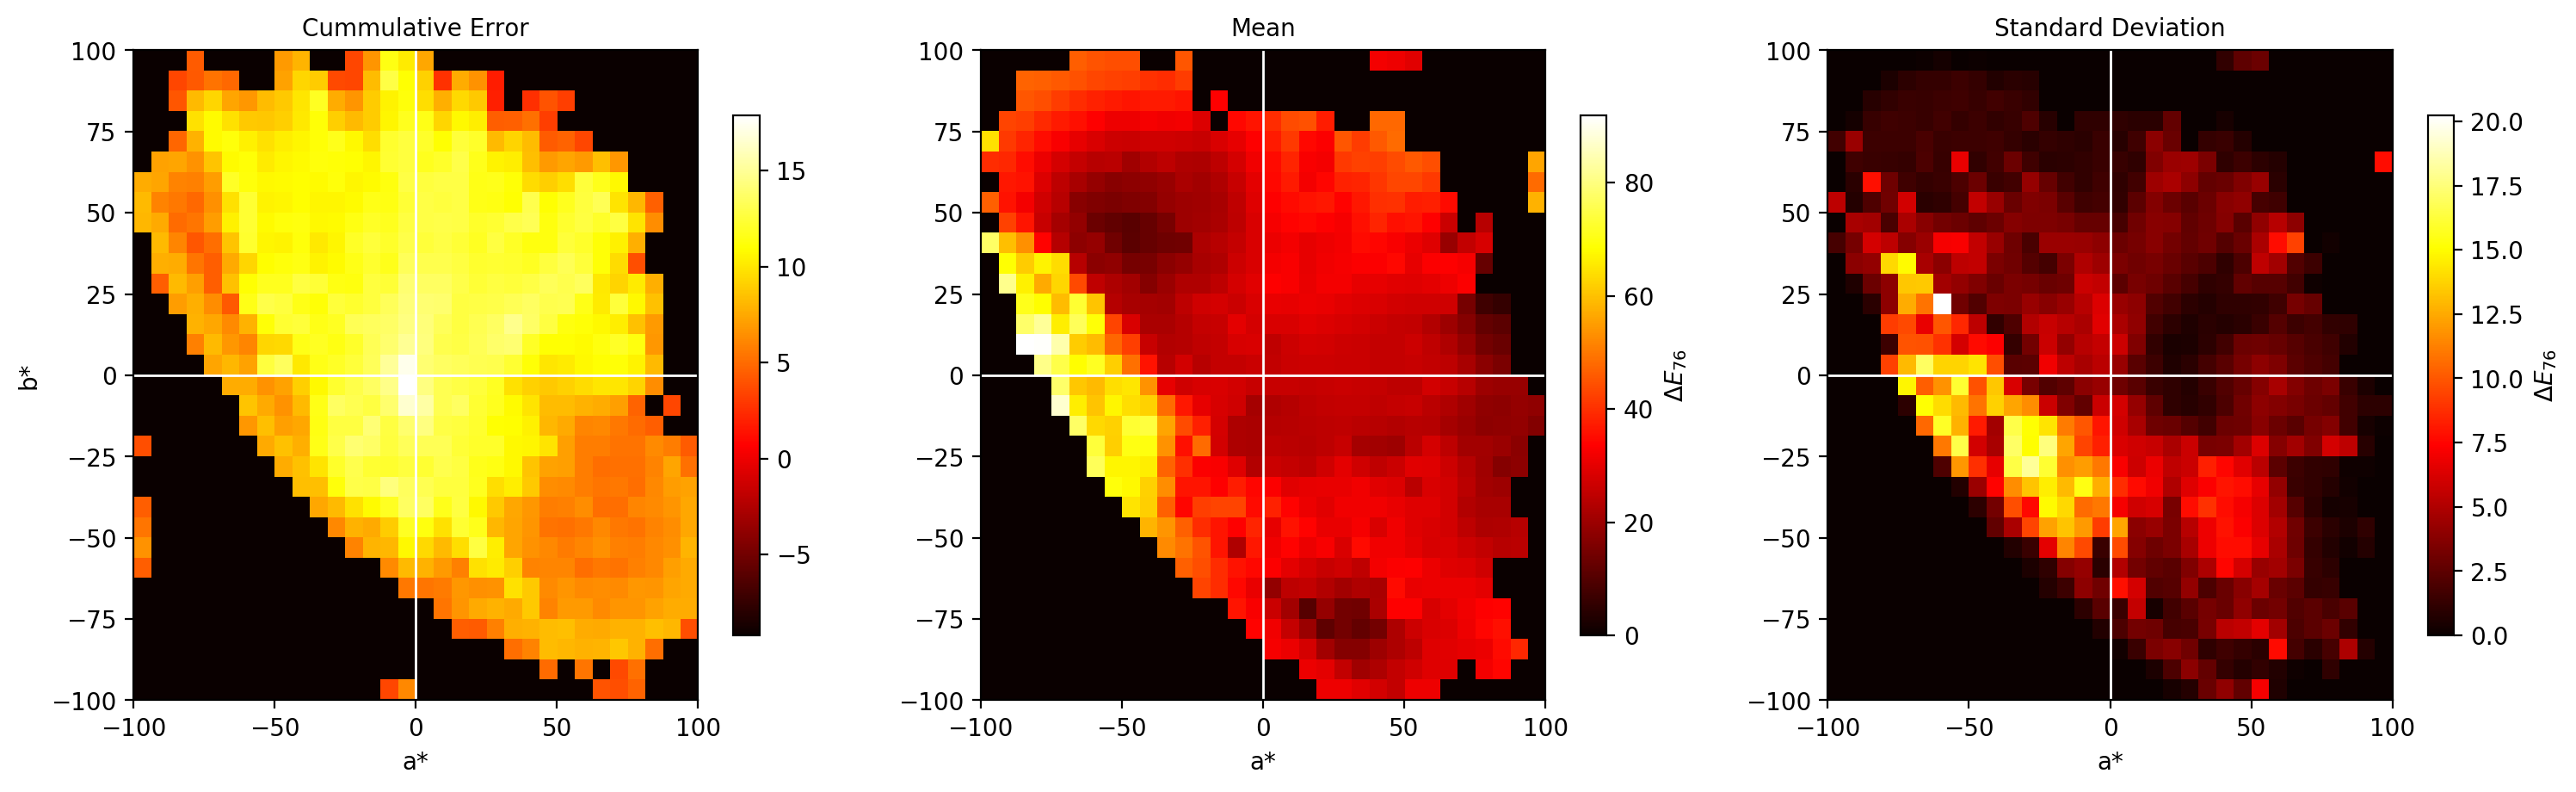

In [142]:
DE76_mean, DE76_std = Error_AB(DE_76_overall[0], 100, "$\Delta E_{76}$", "DE76")

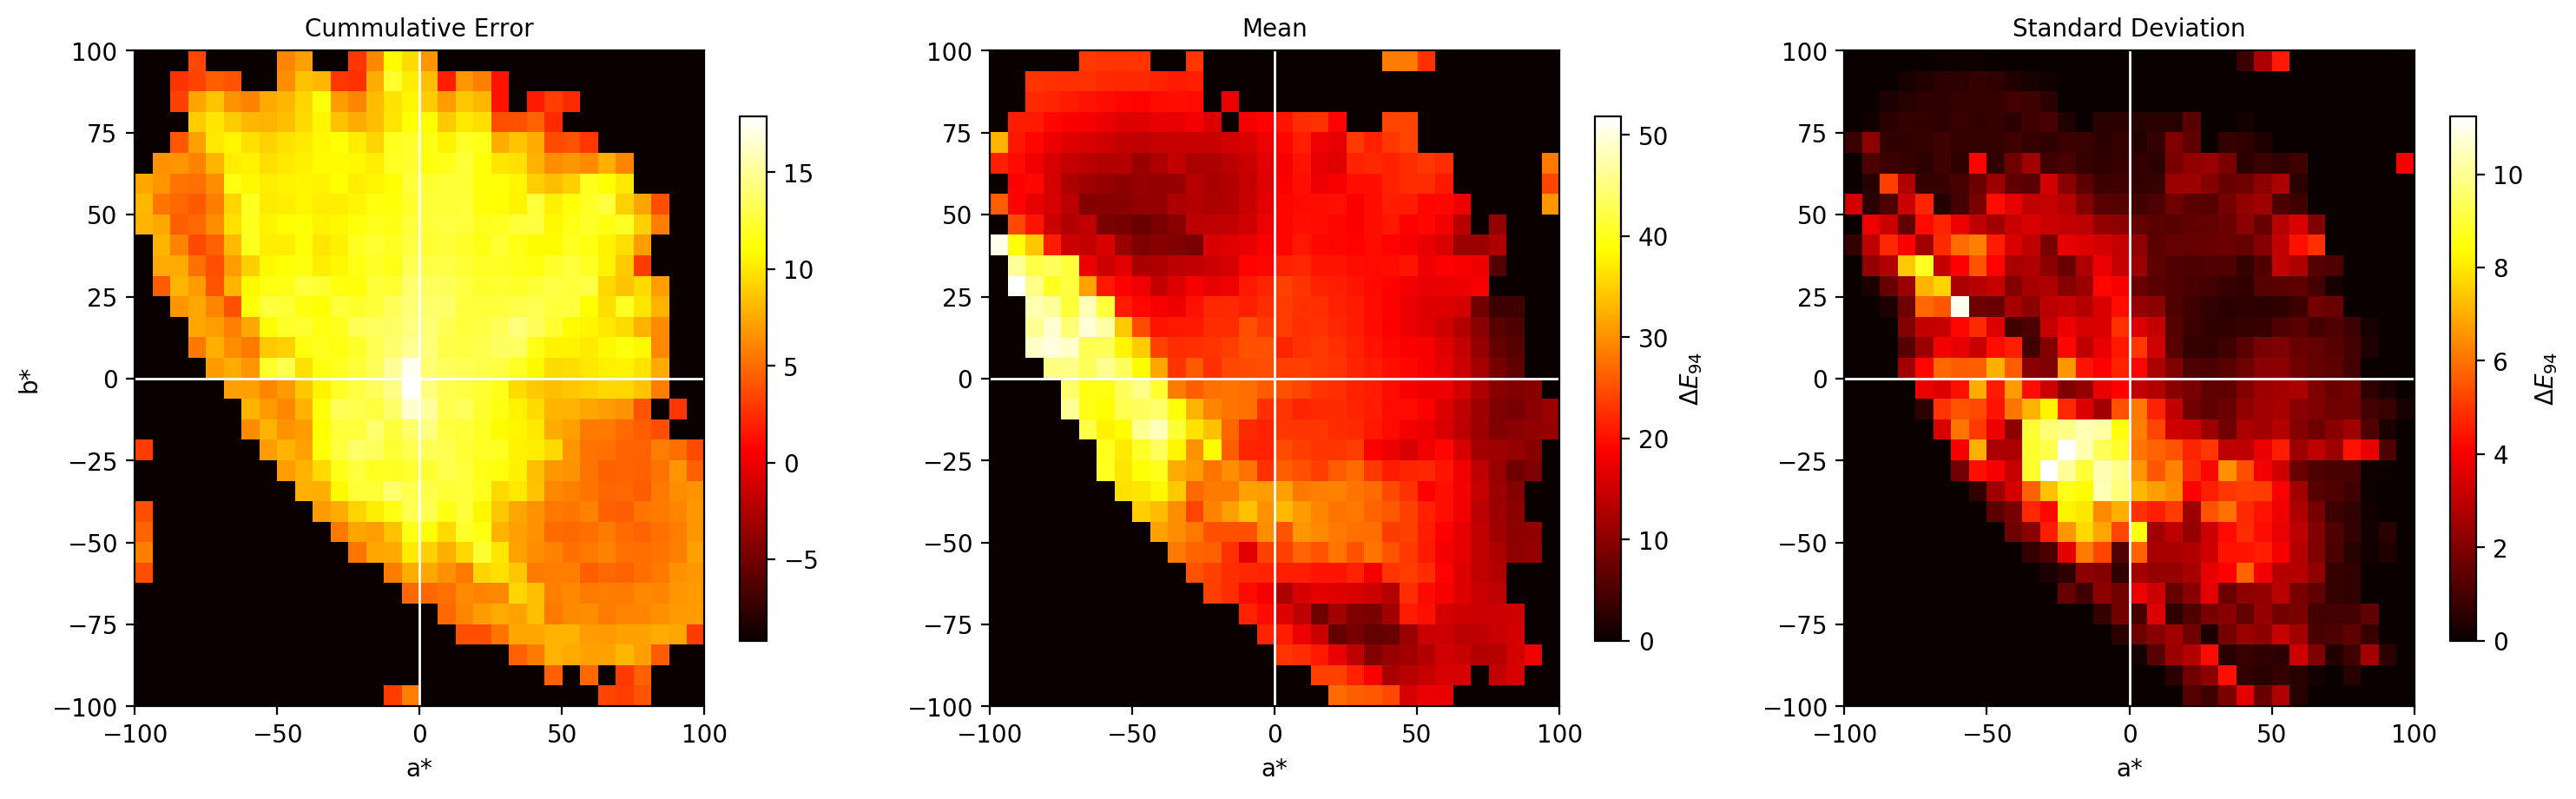

In [143]:
DE94_mean, DE94_std = Error_AB(DE_94_overall[0], 100, "$\Delta E_{94}$", "DE94")

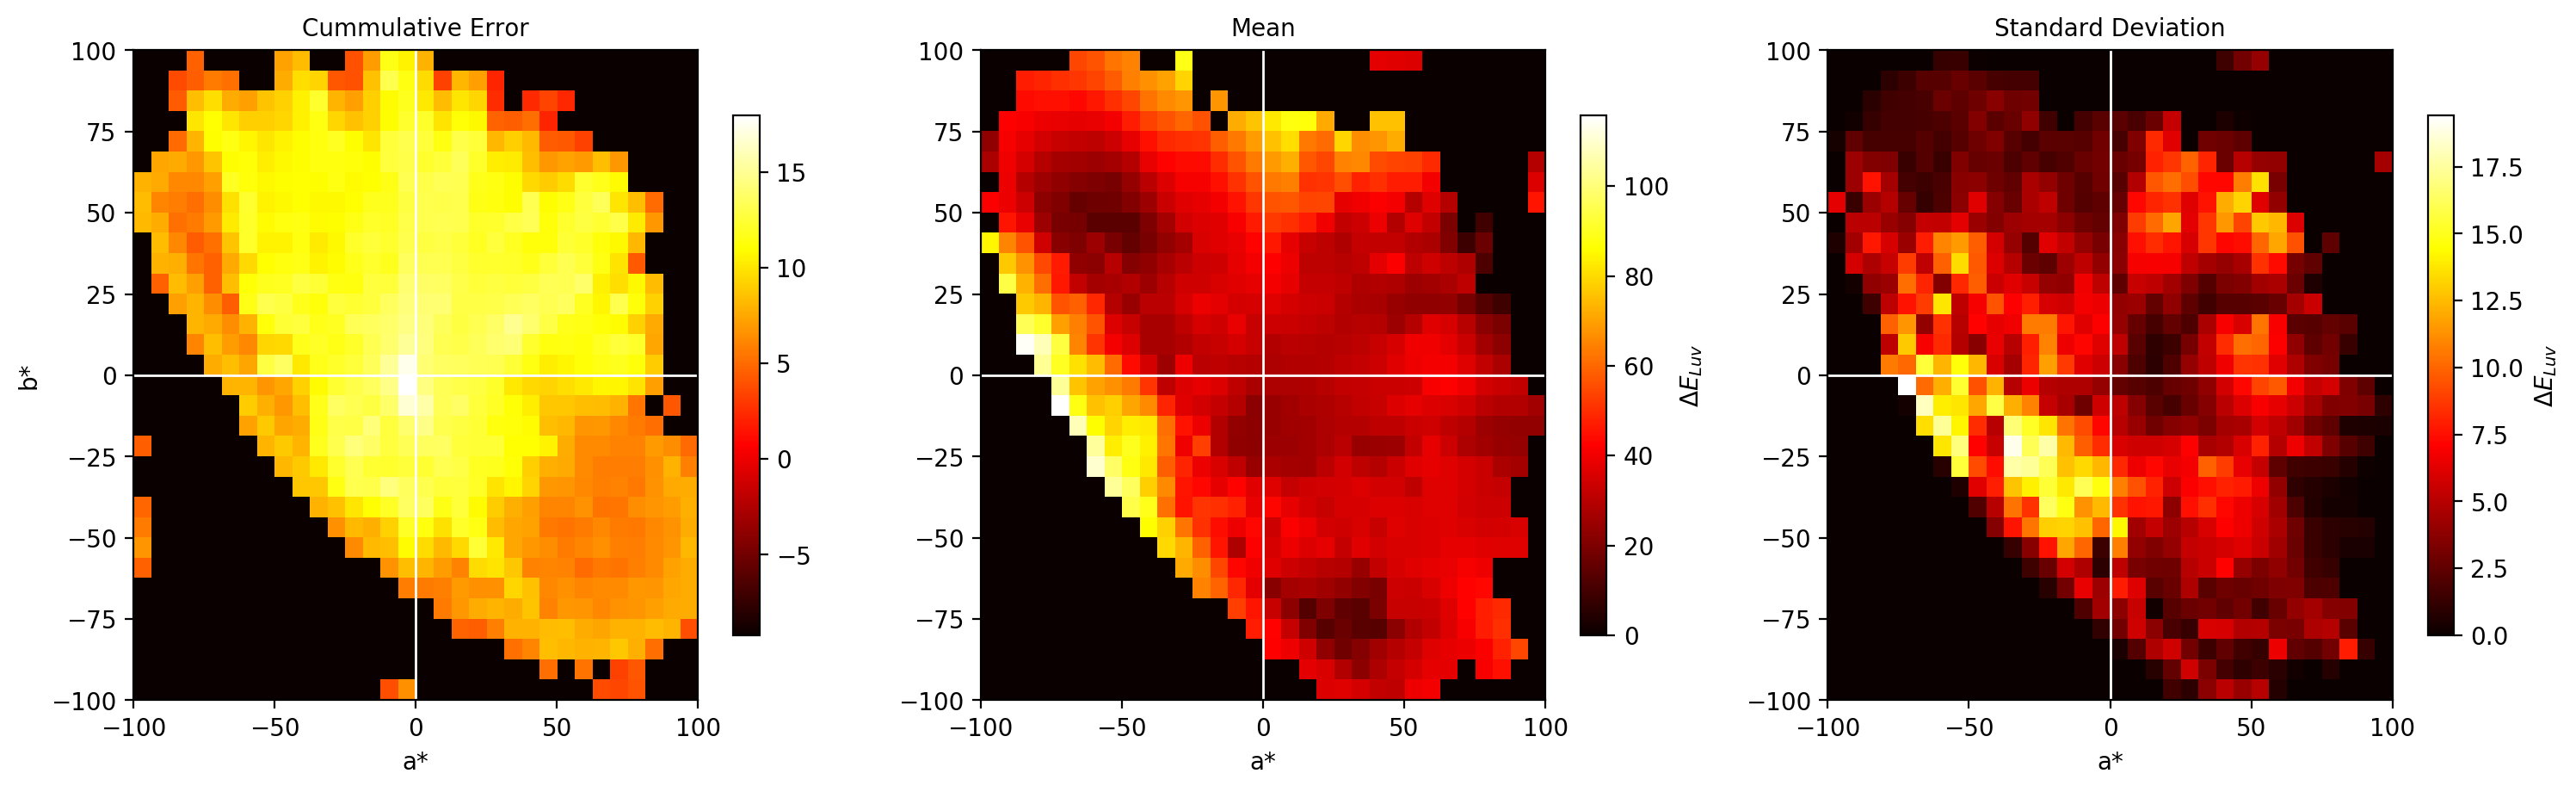

In [144]:
DELUV_mean, DELUV_std = Error_AB(DE_LUV_overall[0], 100, "$\Delta E_{Luv}$", "DELUV")

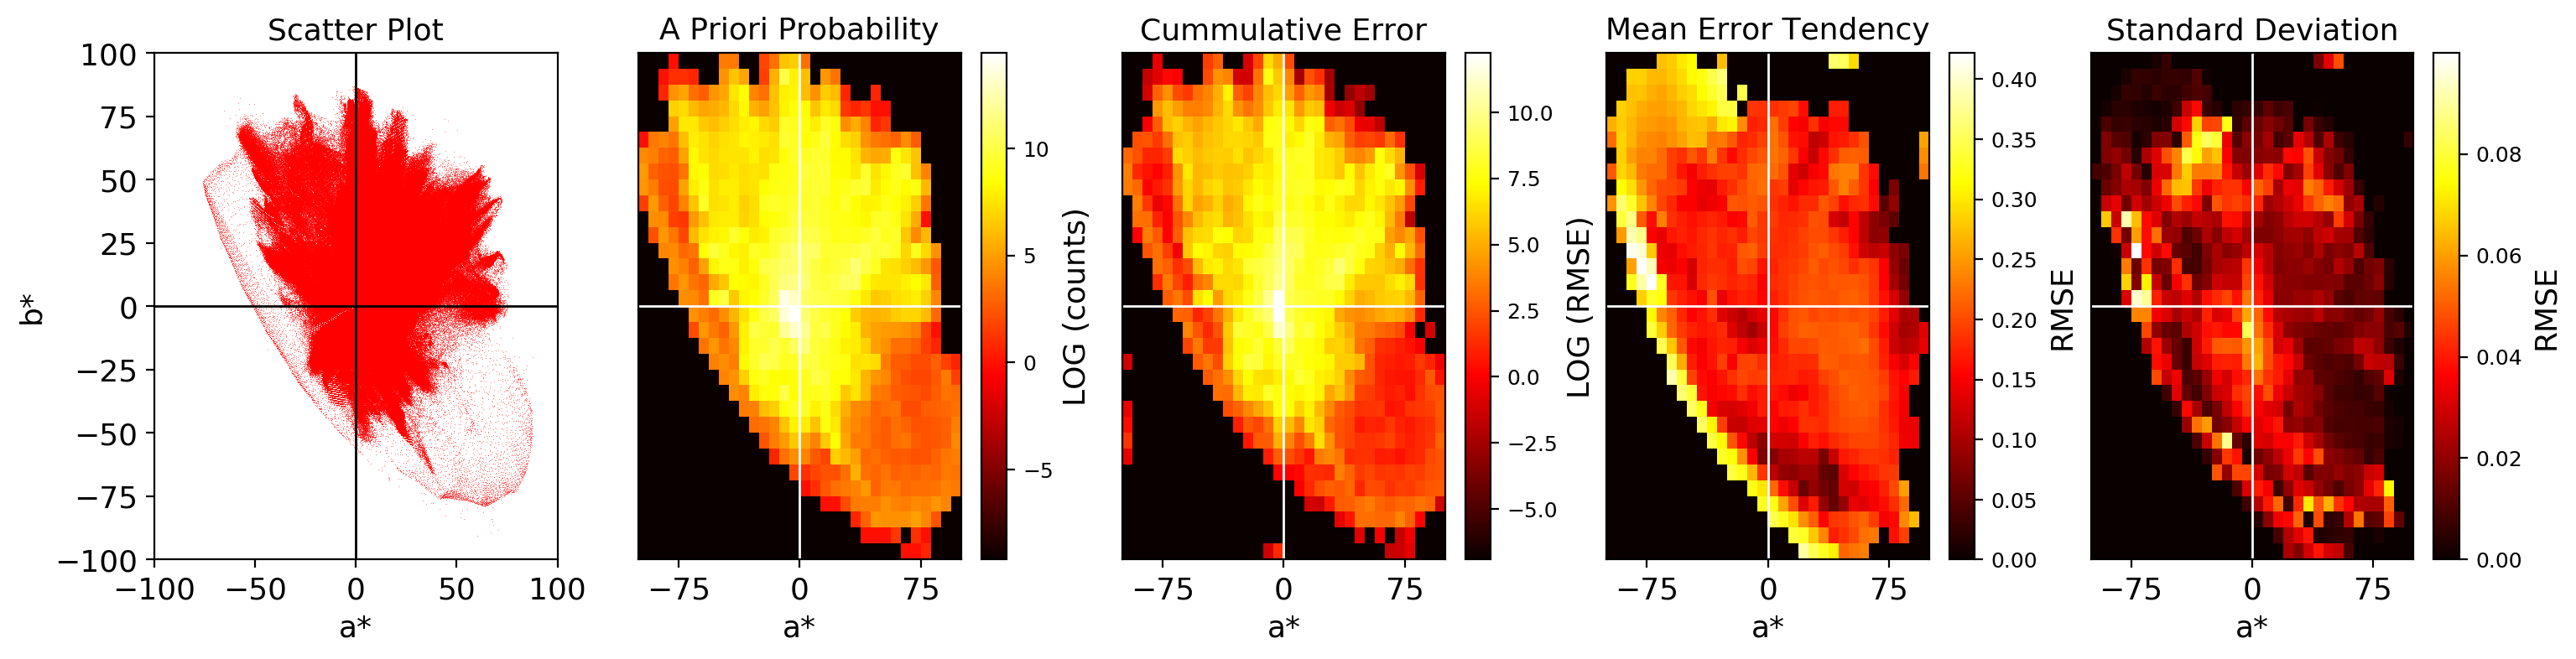

In [152]:
plt.rcParams['axes.titlesize'] = 13
plt.rcParams.update({'font.size': 13})

metric = RMSE_overall[0]
clip = 1
ERROR = "RMSE"

sum_matrix = np.zeros(shape = H_ab.shape)
heat_matrix = np.zeros(shape = H_ab.shape)

for i in range(len(metric)):
    error = metric[i]
    sum_matrix[b_ind[i]-32,a_ind[i]-32] += error

heat_matrix = sum_matrix/count_ab
heat_matrix[heat_matrix> clip] = clip
sum_matrix[sum_matrix==0] = 0.001

ERR = []
for i in range(1024):
    e = []
    ERR.append(e)

for i in range(len(metric)):
    error = metric[i]
    x,y = a_ind[i],b_ind[i]
    m = (x-1)*32 + (y-1)
    ERR[m].append(error)

MEAN = []
STD = []

for i in range(1024):
    MEAN.append(np.mean(ERR[i]))
    STD.append(np.std(ERR[i]))    

MEAN = np.nan_to_num(np.array(MEAN).reshape(32,32))
STD = np.nan_to_num(np.array(STD).reshape(32,32))

fig = plt.figure(constrained_layout=False, dpi = 200, figsize=[18,4], facecolor = 'w')
#fig.suptitle(str(ERROR))
gs1 = fig.add_gridspec(nrows=1, ncols=5)# left=0.05, right=0.48, wspace=0.05)

ax1 = fig.add_subplot(gs1[0, 0])
ax1.plot(A_cave, B_cave, 'r,', alpha = 0.5)
ax1.set_xlim(-100,100)
ax1.set_ylim(-100,100)
ax1.set_title("Scatter Plot")
ax1.set_ylabel("b*")
ax1.set_xlabel("a*")
ax1.axhline(0, color = 'k', linewidth = 1)
ax1.axvline(0, color = 'k', linewidth = 1)
#ax1.set_xticks([-75,0,75])


ax2 = fig.add_subplot(gs1[0, 1])
ax2.set_title("A Priori Probability")
im2 = ax2.imshow(np.log(count_ab), cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
ax2.set_xlabel("a*")
ax2.set_yticks([])
ax2.axhline(0, color = 'w', linewidth = 1)
ax2.axvline(0, color = 'w', linewidth = 1)
ax2.set_xticks([-75,0,75])
cbar = fig.colorbar(im2, shrink=1, label= "LOG (counts)")
cbar.ax.tick_params(labelsize=9) 

ax3 = fig.add_subplot(gs1[0, 2])
ax3.set_title("Cummulative Error")
im3 = ax3.imshow(np.log(sum_matrix), cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
ax3.set_xlabel("a*")
ax3.set_yticks([])
ax3.axhline(0, color = 'w', linewidth = 1)
ax3.axvline(0, color = 'w', linewidth = 1)
ax3.set_xticks([-75,0,75])
cbar = fig.colorbar(im3, shrink=1, label= "LOG (RMSE)")
cbar.ax.tick_params(labelsize=9) 

ax4 = fig.add_subplot(gs1[0, 3])
ax4.set_title("Mean Error Tendency")
im4 = ax4.imshow(MEAN, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
ax4.axhline(0, color = 'w', linewidth = 1)
ax4.axvline(0, color = 'w', linewidth = 1)
ax4.set_xlabel("a*")
ax4.set_yticks([])
ax4.set_xticks([-75,0,75])
cbar = fig.colorbar(im4, shrink=1, label= "RMSE")
cbar.ax.tick_params(labelsize=9) 

ax5 = fig.add_subplot(gs1[0, 4])
ax5.set_title("Standard Deviation")
im5 = ax5.imshow(STD, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
ax5.axhline(0, color = 'w', linewidth = 1)
ax5.axvline(0, color = 'w', linewidth = 1)
ax5.set_xlabel("a*")
ax5.set_yticks([])
ax5.set_xticks([-75,0,75])
cbar = fig.colorbar(im5, shrink=1, label= "RMSE")
cbar.ax.tick_params(labelsize=9) 


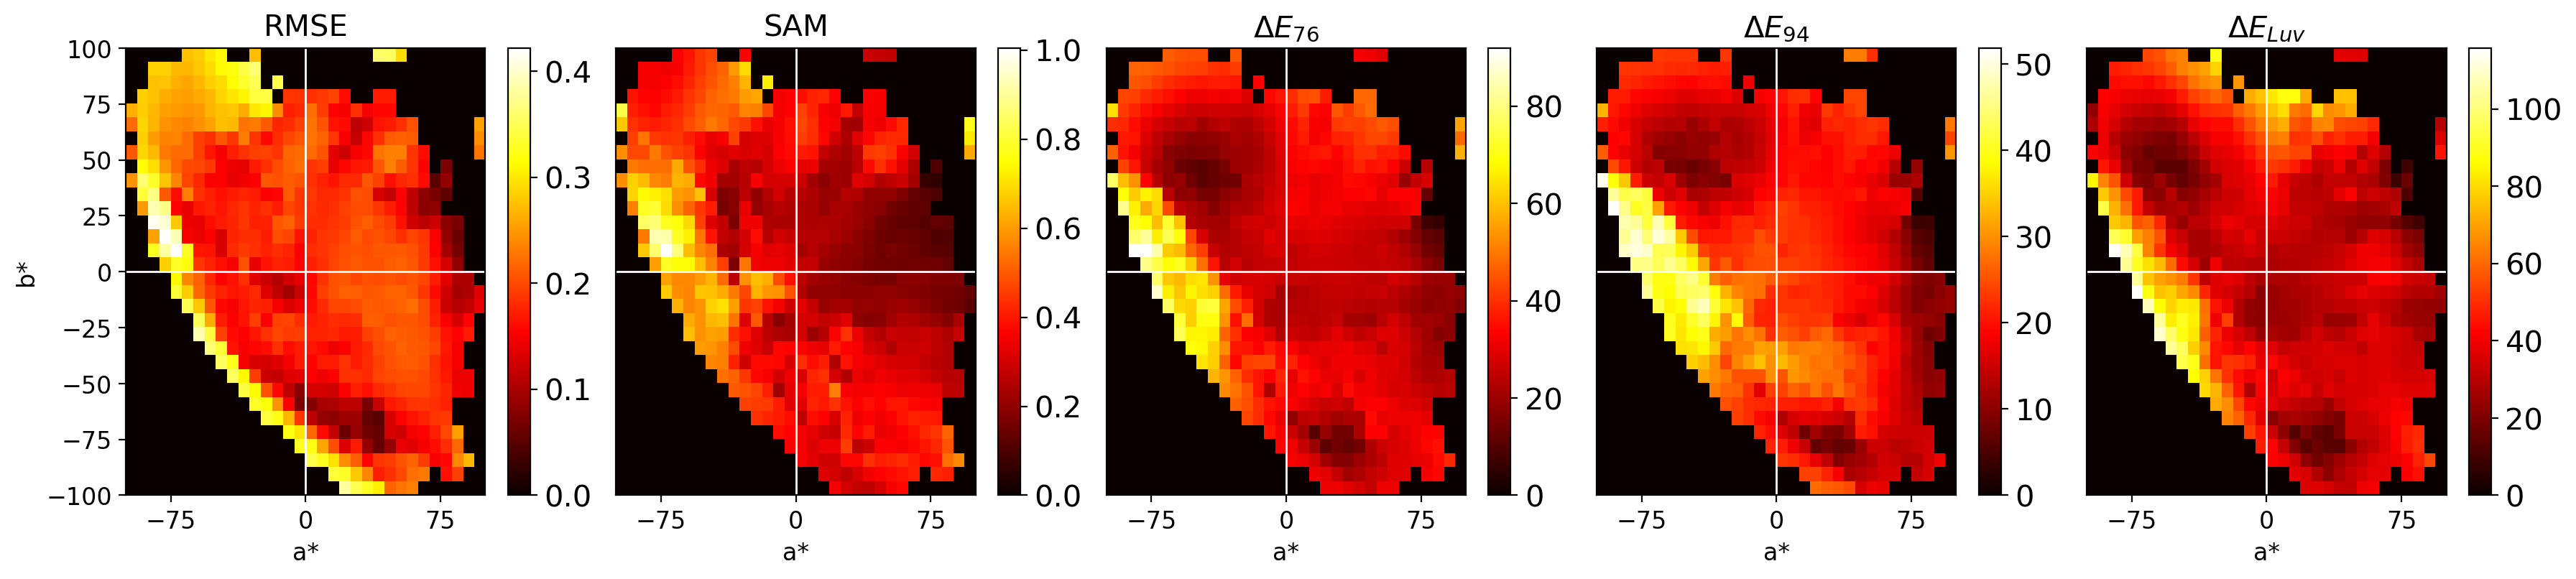

In [150]:
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 12})
ls = 15

fig2 = plt.figure(constrained_layout=False, dpi = 200, figsize=[18,4], facecolor = 'w')

gs2 = fig.add_gridspec(nrows=1, ncols=5)# left=0.05, right=0.48, wspace=0.05)
ax0 = fig2.add_subplot(gs2[0, 0])
im0 = ax0.imshow(RMSE_mean, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im0, shrink=1.0)
cbar.ax.tick_params(labelsize=ls) 
ax0.set_title("RMSE")
ax0.axhline(0, color = 'w', linewidth = 1)
ax0.axvline(0, color = 'w', linewidth = 1)
ax0.set_ylabel("b*")
ax0.set_xlabel("a*")
ax0.set_xticks([-75,0,75])


ax1 = fig2.add_subplot(gs2[0, 1])
im1 = ax1.imshow(SAM_mean, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im1, shrink=1.0)
cbar.ax.tick_params(labelsize=ls) 
ax1.set_title("SAM")
ax1.axhline(0, color = 'w', linewidth = 1)
ax1.axvline(0, color = 'w', linewidth = 1)
ax1.set_xlabel("a*")
ax1.set_yticks([])
ax1.set_xticks([-75,0,75])

ax2 = fig2.add_subplot(gs2[0, 2])
im2 = ax2.imshow(DE76_mean, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im2, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax2.set_yticks([])
ax2.set_title("$\Delta E_{76}$")
ax2.axhline(0, color = 'w', linewidth = 1)
ax2.axvline(0, color = 'w', linewidth = 1)
ax2.set_xlabel("a*")
ax2.set_xticks([-75,0,75])


ax3 = fig2.add_subplot(gs2[0, 3])
im3 = ax3.imshow(DE94_mean, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im3, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax3.set_yticks([])
ax3.set_title("$\Delta E_{94}$")
ax3.axhline(0, color = 'w', linewidth = 1)
ax3.axvline(0, color = 'w', linewidth = 1)
ax3.set_xlabel("a*")
ax3.set_xticks([-75,0,75])

ax4 = fig2.add_subplot(gs2[0, 4])
im4 = ax4.imshow(DELUV_mean, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im4, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax4.set_yticks([])
ax4.set_title("$\Delta E_{Luv}$")
ax4.set_xticks([-75,0,75])
ax4.axhline(0, color = 'w', linewidth = 1)
ax4.axvline(0, color = 'w', linewidth = 1)
ax4.set_xlabel("a*")

plt.tight_layout(pad=0.5, w_pad=0.1, h_pad=0.5)
fig2.savefig(results_path + "CAVE_ET_mean.png", bbox_inches='tight', transparent=True)

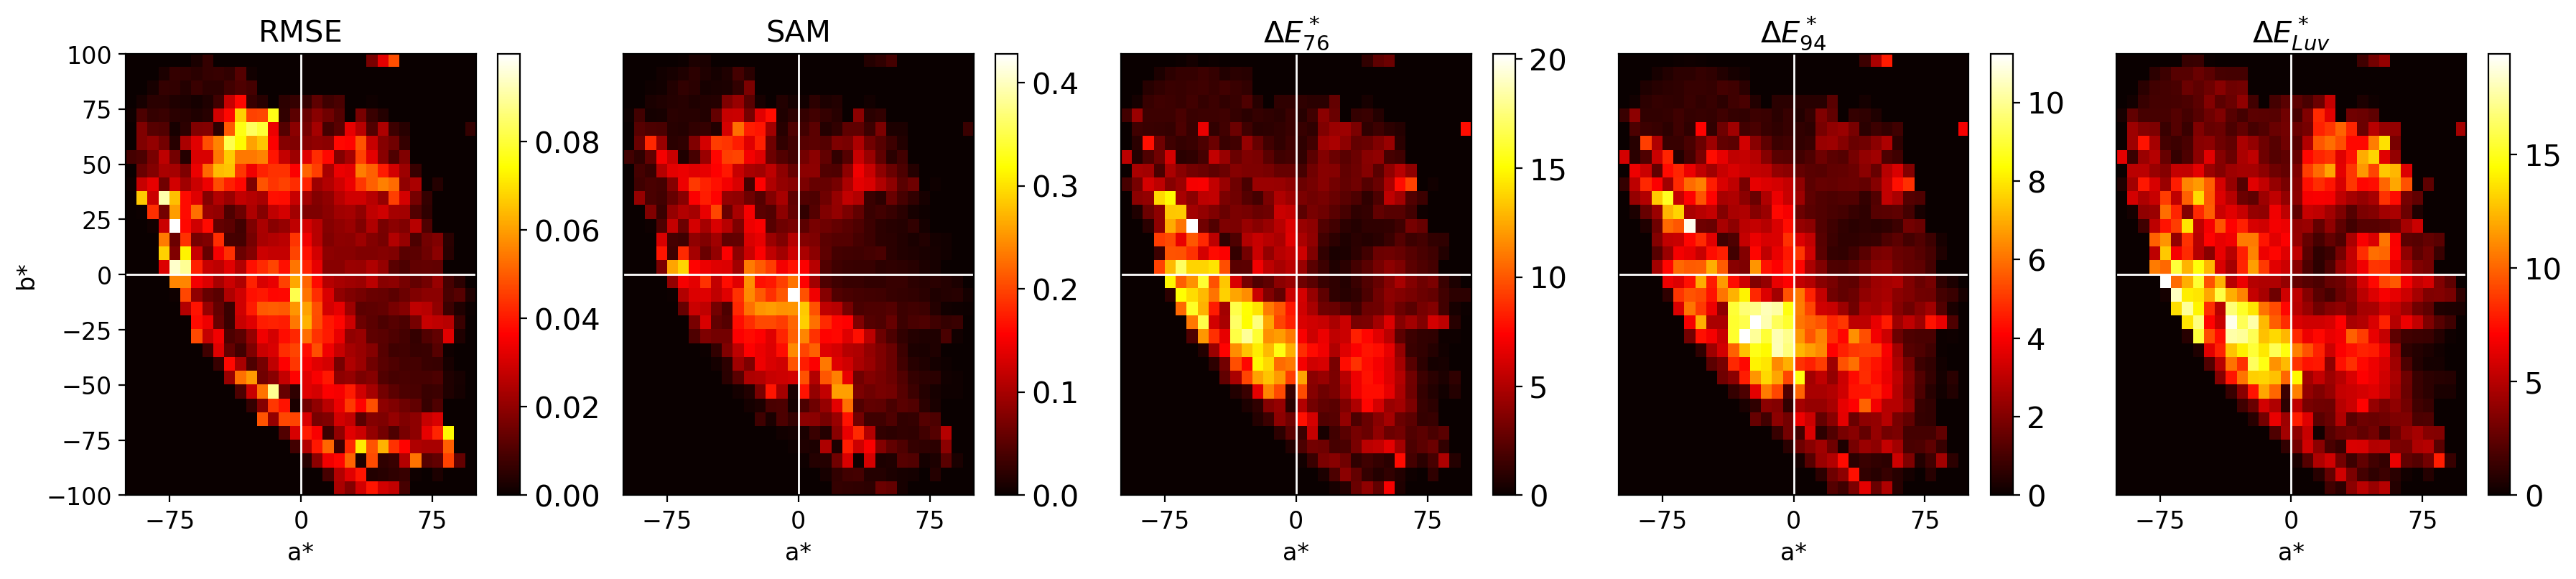

In [151]:
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 12})
ls = 15

fig2 = plt.figure(constrained_layout=False, dpi = 200, figsize=[18,4], facecolor = 'w')

gs2 = fig.add_gridspec(nrows=1, ncols=5)# left=0.05, right=0.48, wspace=0.05)
ax0 = fig2.add_subplot(gs2[0, 0])
im0 = ax0.imshow(RMSE_std, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im0, shrink=1.0)
cbar.ax.tick_params(labelsize=ls) 
ax0.set_title("RMSE")
ax0.axhline(0, color = 'w', linewidth = 1)
ax0.axvline(0, color = 'w', linewidth = 1)
ax0.set_ylabel("b*")
ax0.set_xlabel("a*")
ax0.set_xticks([-75,0,75])


ax1 = fig2.add_subplot(gs2[0, 1])
im1 = ax1.imshow(SAM_std, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im1, shrink=1.0)
cbar.ax.tick_params(labelsize=ls) 
ax1.set_title("SAM")
ax1.axhline(0, color = 'w', linewidth = 1)
ax1.axvline(0, color = 'w', linewidth = 1)
ax1.set_xlabel("a*")
ax1.set_yticks([])
ax1.set_xticks([-75,0,75])

ax2 = fig2.add_subplot(gs2[0, 2])
im2 = ax2.imshow(DE76_std, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im2, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax2.set_yticks([])
ax2.set_title("$\Delta E^*_{76}$")
ax2.axhline(0, color = 'w', linewidth = 1)
ax2.axvline(0, color = 'w', linewidth = 1)
ax2.set_xlabel("a*")
ax2.set_xticks([-75,0,75])


ax3 = fig2.add_subplot(gs2[0, 3])
im3 = ax3.imshow(DE94_std, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im3, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax3.set_yticks([])
ax3.set_title("$\Delta E^*_{94}$")
ax3.axhline(0, color = 'w', linewidth = 1)
ax3.axvline(0, color = 'w', linewidth = 1)
ax3.set_xlabel("a*")
ax3.set_xticks([-75,0,75])

ax4 = fig2.add_subplot(gs2[0, 4])
im4 = ax4.imshow(DELUV_std, cmap = CMAP, origin = "lower", extent=[-100,100,-100,100], aspect='auto')
cbar = fig2.colorbar(im4, shrink=1)
cbar.ax.tick_params(labelsize=ls) 
ax4.set_yticks([])
ax4.set_title("$\Delta E^*_{Luv}$")
ax4.set_xticks([-75,0,75])
ax4.axhline(0, color = 'w', linewidth = 1)
ax4.axvline(0, color = 'w', linewidth = 1)
ax4.set_xlabel("a*")
plt.tight_layout(pad=0.5, w_pad=0.1, h_pad=0.5)
fig2.savefig(results_path + "CAVE_ET_std.png", bbox_inches='tight', transparent=True)